*The analysis of pleiotropy was performed by Polina Bogaichuk*

In [1]:
#!/usr/bin/env python3

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 5)

### Part 1 - General view of the table

In [4]:
# importing the main table

def converter(x):
    if x != '':
        return x.split(',')

base_HPO_table = pd.read_csv("../databases/human_mouse_GPO.tsv",
                   delimiter='\t',
                   converters={'MP_PhenoGeno': converter, 'HP_genes_to_phenotype': converter, 'MP_system_level': converter,
                               'HP_system_level': converter, 'MP_from_HP_system_level': converter},
                   usecols=lambda col: col != 'MP_HMD')

base_HPO_table = base_HPO_table.rename(columns={
    'MP_PhenoGeno': 'MP_low_level',
    'HP_genes_to_phenotype': 'HP_low_level',
    'MP_system_level': 'MP_high_level',
    'HP_system_level': 'HP_high_level_human',
    'MP_from_HP_system_level': 'HP_high_level'
})

base_HPO_table

,gene_human,entrez_id_human,gene_mouse,MGI,MP_low_level,HP_low_level,MP_high_level,HP_high_level_human,HP_high_level
0,A1BG,1,A1bg,MGI:2152878,None,None,None,None,None
1,A1CF,29974,A1cf,MGI:1917115,"[MP:0001855, MP:0005266, MP:0008772, MP:000531...",None,"[MP:0005367, MP:0005385, MP:0005386, MP:000537...",None,None
...,...,...,...,...,...,...,...,...,...
29684,ZZEF1,23140,Zzef1,MGI:2444286,"[MP:0005561, MP:0010123, MP:0003063, MP:000125...",None,"[MP:0005367, MP:0005390, MP:0005397, MP:000538...",None,None
29685,ZZZ3,26009,Zzz3,MGI:1920453,None,None,None,None,None


In [5]:
# leave only genes with a definite pair in humans and mice

gene_count_human = pd.DataFrame(base_HPO_table.entrez_id_human.value_counts())\
    .reset_index()\
    .rename(columns={"count": "count_human"})

gene_count_mouse = pd.DataFrame(base_HPO_table.MGI.value_counts())\
    .reset_index()\
    .rename(columns={"count": "count_mouse"})

db_syst_gene_count = base_HPO_table.merge(gene_count_human, on="entrez_id_human", how="left").merge(gene_count_mouse, on="MGI", how="left")

main_HPO_table = db_syst_gene_count[(db_syst_gene_count.count_human == 1) & (db_syst_gene_count.count_mouse == 1)]
main_HPO_table = main_HPO_table.drop(['count_human', 'count_mouse'], axis=1)

In [6]:
# adding gene IDs for mice

mgi_gene = pd.read_csv('../databases/MGI2ID.csv', delimiter=';', usecols=range(6))
main_HPO_table = main_HPO_table.merge(mgi_gene, how='left', left_on='MGI', right_on='MGI_accession_id')
main_HPO_table = main_HPO_table.rename(columns={'Entrez_gene_id': 'entrez_id_mouse'})
main_HPO_table = main_HPO_table.loc[:, ['gene_human', 'entrez_id_human', 'gene_mouse', 'MGI', 'entrez_id_mouse', 'MP_low_level',
                                        'HP_low_level', 'MP_high_level', 'HP_high_level_human', 'HP_high_level']].copy()
main_HPO_table

,gene_human,entrez_id_human,gene_mouse,MGI,entrez_id_mouse,MP_low_level,HP_low_level,MP_high_level,HP_high_level_human,HP_high_level
0,A1BG,1,A1bg,MGI:2152878,117586.0,None,None,None,None,None
1,A1CF,29974,A1cf,MGI:1917115,69865.0,"[MP:0001855, MP:0005266, MP:0008772, MP:000531...",None,"[MP:0005367, MP:0005385, MP:0005386, MP:000537...",None,None
...,...,...,...,...,...,...,...,...,...,...
16983,ZZEF1,23140,Zzef1,MGI:2444286,195018.0,"[MP:0005561, MP:0010123, MP:0003063, MP:000125...",None,"[MP:0005367, MP:0005390, MP:0005397, MP:000538...",None,None
16984,ZZZ3,26009,Zzz3,MGI:1920453,108946.0,None,None,None,None,None


In [7]:
# look at some numbers
print("Total gene number is: ", main_HPO_table.shape[0]) # 29686 genes

# for human
unique_genes_h = main_HPO_table['entrez_id_human'].nunique()
genes_with_HPO_terms = main_HPO_table[main_HPO_table['HP_low_level'].notna()]['entrez_id_human'].count()
genes_with_HPO__system_terms = main_HPO_table[main_HPO_table['HP_high_level'].notna()]['entrez_id_human'].count()
unique_HPO_terms = main_HPO_table['HP_low_level'].explode().nunique()
unique_system_HPO_terms_human = main_HPO_table['HP_high_level_human'].explode().nunique()
unique_system_HPO_terms = main_HPO_table['HP_high_level'].explode().nunique()

print('HUMAN')
print("Number of unique human genes: ", unique_genes_h)
print("Number of genes with at least one HPO term: ", genes_with_HPO_terms)
print("Number of genes with at least one system HPO term: ", genes_with_HPO__system_terms)
print("Number of unique HPO terms found: ", unique_HPO_terms)
print("Number of unique system-level HPO terms found: ", unique_system_HPO_terms_human)
print("Number of unique system-level HPO (from MP) terms found: ", unique_system_HPO_terms)



# for mouse
unique_genes_m = main_HPO_table['MGI'].nunique()
genes_with_MPO_terms = main_HPO_table[main_HPO_table['MP_low_level'].notna()]['MGI'].count()
genes_with_MPO__system_terms = main_HPO_table[main_HPO_table['MP_high_level'].notna()]['MGI'].count()
unique_MPO_terms = main_HPO_table['MP_low_level'].explode().nunique()
unique_system_MPO_terms = main_HPO_table['MP_high_level'].explode().nunique()

print('MOUSE')
print("Number of unique mouse genes: ", unique_genes_m)
print("Number of genes with at least one MPO term: ", genes_with_MPO_terms)
print("Number of genes with at least one system MPO term: ", genes_with_MPO__system_terms)
print("Number of unique MPO terms found: ", unique_MPO_terms)
print("Number of unique system-level MPO terms found: ", unique_system_MPO_terms)


Total gene number is:  16985
HUMAN
Number of unique human genes:  16985
Number of genes with at least one HPO term:  4602
Number of genes with at least one system HPO term:  4600
Number of unique HPO terms found:  9210
Number of unique system-level HPO terms found:  91
Number of unique system-level HPO (from MP) terms found:  25
MOUSE
Number of unique mouse genes:  16985
Number of genes with at least one MPO term:  12371
Number of genes with at least one system MPO term:  12098
Number of unique MPO terms found:  10632
Number of unique system-level MPO terms found:  25


### Part 2 - Examining the table with HPO terms only

In [8]:
# look at some numbers 
num_HPO_terms = main_HPO_table['HP_low_level'].apply(lambda x: len(x) if x is not None else None)
avg_HPO_terms = num_HPO_terms.mean()
std_HPO_terms = num_HPO_terms.std()
median_HPO_terms = num_HPO_terms.median()
q1_HPO_terms = num_HPO_terms.quantile(0.25)
q3_HPO_terms = num_HPO_terms.quantile(0.75)
min_HPO_terms = num_HPO_terms.min()
max_HPO_terms = num_HPO_terms.max()


print("LOW_LEVEL")
print("M ± SD: {:.0f} ± {:.0f}".format(avg_HPO_terms, std_HPO_terms))
print("Me (IQR): {:.0f} ({:.0f}-{:.0f})".format(median_HPO_terms, q1_HPO_terms, q3_HPO_terms))
print("Min-Max: {}-{}".format(min_HPO_terms, max_HPO_terms))


num_system_HPO_terms = main_HPO_table['HP_high_level'].apply(lambda x: len(x) if x is not None else None)
avg_system_HPO_terms = num_system_HPO_terms.mean()
std_system_HPO_terms = num_system_HPO_terms.std()
median_system_HPO_terms = num_system_HPO_terms.median()
q1_system_HPO_terms = num_system_HPO_terms.quantile(0.25)
q3_system_HPO_terms = num_system_HPO_terms.quantile(0.75)
min_system_HPO_terms = num_system_HPO_terms.min()
max_system_HPO_terms = num_system_HPO_terms.max()

print("SYSTEM_LEVEL")
print("M ± SD: {:.0f} ± {:.0f}".format(avg_system_HPO_terms, std_system_HPO_terms))
print("Me (IQR): {:.0f} ({:.0f}-{:.0f})".format(median_system_HPO_terms, q1_system_HPO_terms, q3_system_HPO_terms))
print("Min-Max: {}-{}".format(min_system_HPO_terms, max_system_HPO_terms))


num_system_HHPO_terms = main_HPO_table['HP_high_level_human'].apply(lambda x: len(x) if x is not None else None)
avg_system_HHPO_terms = num_system_HHPO_terms.mean()
std_system_HHPO_terms = num_system_HHPO_terms.std()
median_system_HHPO_terms = num_system_HHPO_terms.median()
q1_system_HHPO_terms = num_system_HHPO_terms.quantile(0.25)
q3_system_HHPO_terms = num_system_HHPO_terms.quantile(0.75)
min_system_HHPO_terms = num_system_HHPO_terms.min()
max_system_HHPO_terms = num_system_HHPO_terms.max()

print("SYSTEM_LEVEL_HUMAN")
print("M ± SD: {:.0f} ± {:.0f}".format(avg_system_HHPO_terms, std_system_HHPO_terms))
print("Me (IQR): {:.0f} ({:.0f}-{:.0f})".format(median_system_HHPO_terms, q1_system_HHPO_terms, q3_system_HHPO_terms))
print("Min-Max: {}-{}".format(min_system_HHPO_terms, max_system_HHPO_terms))

LOW_LEVEL
M ± SD: 56 ± 62
Me (IQR): 37 (17-72)
Min-Max: 1.0-741.0
SYSTEM_LEVEL
M ± SD: 10 ± 6
Me (IQR): 11 (6-15)
Min-Max: 1.0-25.0
SYSTEM_LEVEL_HUMAN
M ± SD: 13 ± 8
Me (IQR): 12 (6-18)
Min-Max: 1.0-49.0


In [9]:
# create new columns with the number of terms

main_HPO_table.loc[:, 'HP_count'] = main_HPO_table['HP_low_level'].apply(lambda x: len(x) if x is not None else None)
main_HPO_table.loc[:, 'HP_high_count'] = main_HPO_table['HP_high_level'].apply(lambda x: len(x) if x is not None else None)

In [10]:
# see what genes have the most HPO terms

sorted_table = main_HPO_table.sort_values(by='HP_high_count', ascending=False)
sorted_table

,gene_human,entrez_id_human,gene_mouse,MGI,entrez_id_mouse,MP_low_level,HP_low_level,MP_high_level,HP_high_level_human,HP_high_level,HP_count,HP_high_count
4537,ERCC4,2072,Ercc4,MGI:1354163,50505.0,"[MP:0010207, MP:0011083, MP:0010053, MP:001110...","[HP:0000238, HP:0004349, HP:0000582, HP:000626...","[MP:0005385, MP:0005391, MP:0005386, MP:000537...","[HP:0000478, HP:0001871, HP:0001507, HP:000266...","[MP:0002006, MP:0005391, MP:0005386, MP:000537...",301.0,25.0
7662,LMNA,4000,Lmna,MGI:96794,16905.0,"[MP:0002060, MP:0009865, MP:0000149, MP:000218...","[HP:0005150, HP:0000855, HP:0000869, HP:000371...","[MP:0005375, MP:0005371, MP:0005391, MP:000538...","[HP:0000478, HP:0001507, HP:0001871, HP:000266...","[MP:0002006, MP:0005391, MP:0005386, MP:000537...",741.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16983,ZZEF1,23140,Zzef1,MGI:2444286,195018.0,"[MP:0005561, MP:0010123, MP:0003063, MP:000125...",None,"[MP:0005367, MP:0005390, MP:0005397, MP:000538...",None,None,NaN,NaN
16984,ZZZ3,26009,Zzz3,MGI:1920453,108946.0,None,None,None,None,None,NaN,NaN


### Part 3 - Examining the table with MPO terms only

In [11]:
# look at some numbers

num_MPO_terms = main_HPO_table['MP_low_level'].apply(lambda x: len(x) if x is not None else None)
avg_MPO_terms = num_MPO_terms.mean()
std_MPO_terms = num_MPO_terms.std()
median_MPO_terms = num_MPO_terms.median()
q1_MPO_terms = num_MPO_terms.quantile(0.25)
q3_MPO_terms = num_MPO_terms.quantile(0.75)
min_MPO_terms = num_MPO_terms.min()
max_MPO_terms = num_MPO_terms.max()


print("LOW_LEVEL")
print("M ± SD: {:.0f} ± {:.0f}".format(avg_MPO_terms, std_MPO_terms))
print("Me (IQR): {:.0f} ({:.0f}-{:.0f})".format(median_MPO_terms, q1_MPO_terms, q3_MPO_terms))
print("Min-Max: {}-{}".format(min_MPO_terms, max_MPO_terms))


num_system_MPO_terms = main_HPO_table['MP_high_level'].apply(lambda x: len(x) if x is not None else None)
avg_system_MPO_terms = num_system_MPO_terms.mean()
std_system_MPO_terms = num_system_MPO_terms.std()
median_system_MPO_terms = num_system_MPO_terms.median()
q1_system_MPO_terms = num_system_MPO_terms.quantile(0.25)
q3_system_MPO_terms = num_system_MPO_terms.quantile(0.75)
min_system_MPO_terms = num_system_MPO_terms.min()
max_system_MPO_terms = num_system_MPO_terms.max()

print("SYSTEM_LEVEL")
print("M ± SD: {:.0f} ± {:.0f}".format(avg_system_MPO_terms, std_system_MPO_terms))
print("Me (IQR): {:.0f} ({:.0f}-{:.0f})".format(median_system_MPO_terms, q1_system_MPO_terms, q3_system_MPO_terms))
print("Min-Max: {}-{}".format(min_system_MPO_terms, max_system_MPO_terms))

LOW_LEVEL
M ± SD: 21 ± 38
Me (IQR): 10 (4-24)
Min-Max: 1.0-2027.0
SYSTEM_LEVEL
M ± SD: 6 ± 5
Me (IQR): 5 (3-9)
Min-Max: 1.0-25.0


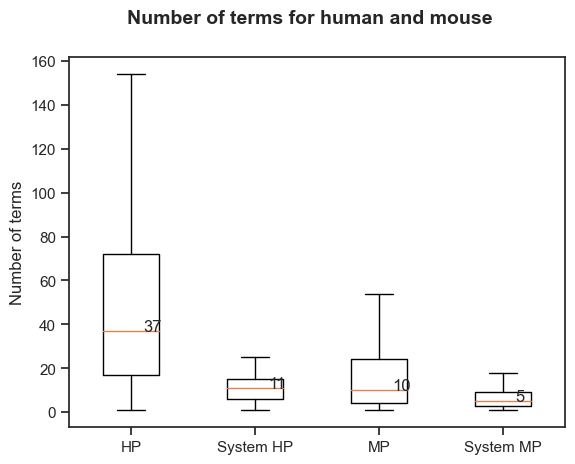

In [103]:
# look at the boxplot
num_HPO_terms.dropna(inplace=True)
num_system_HPO_terms.dropna(inplace=True)
num_MPO_terms.dropna(inplace=True)
num_system_MPO_terms.dropna(inplace=True)


data = [num_HPO_terms, num_system_HPO_terms, num_MPO_terms, num_system_MPO_terms]

labels = ['HP', 'System HP', 'MP', 'System MP']
ylabel = 'Number of terms'

fig, ax = plt.subplots()
boxes = ax.boxplot(data, showfliers=False) # это без выбросов

ax.set_xticklabels(labels)
ax.set_ylabel(ylabel)

medians = [box.get_ydata()[0] for box in boxes['medians']]
for i in range(len(medians)):
    median = medians[i]
    x_pos = i + 1
    y_pos = median
    ax.annotate('{:.0f}'.format(y_pos), xy=(x_pos, y_pos), xytext=(x_pos + 0.1, y_pos))

fig.suptitle('Number of terms for human and mouse', fontsize=14, fontweight='bold')

plt.savefig("../pictures/plei_01_low_and_system_HPO.png", dpi=300)

plt.show()


In [14]:
# create new columns with the number of terms

main_HPO_table.loc[:, 'MP_count'] = main_HPO_table['MP_low_level'].apply(lambda x: len(x) if x is not None else None)
main_HPO_table.loc[:, 'MP_high_count'] = main_HPO_table['MP_high_level'].apply(lambda x: len(x) if x is not None else None)

In [15]:
# see what genes have the most MPO terms

sorted_table = main_HPO_table.sort_values(by='MP_high_count', ascending=False)
sorted_table

,gene_human,entrez_id_human,gene_mouse,MGI,entrez_id_mouse,MP_low_level,HP_low_level,MP_high_level,HP_high_level_human,HP_high_level,HP_count,HP_high_count,MP_count,MP_high_count
3038,COL1A1,1277,Col1a1,MGI:88467,12842.0,"[MP:0002413, MP:0009378, MP:0000589, MP:000052...","[HP:0000006, HP:0000963, HP:0002645, HP:000494...","[MP:0002006, MP:0005375, MP:0005371, MP:000539...","[HP:0012531, HP:0002019, HP:0001789, HP:001237...","[MP:0002006, MP:0005391, MP:0005386, MP:000537...",241.0,21.0,438.0,25.0
5040,FGFR2,2263,Fgfr2,MGI:95523,14183.0,"[MP:0000435, MP:0004985, MP:0001175, MP:000479...","[HP:0000006, HP:0005280, HP:0000238, HP:000048...","[MP:0002006, MP:0005375, MP:0005371, MP:000539...","[HP:0001732, HP:0000478, HP:0007379, HP:000150...","[MP:0002006, MP:0005391, MP:0005386, MP:000537...",687.0,21.0,428.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16980,ZYG11A,440590,Zyg11a,MGI:2446208,230590.0,None,None,None,None,None,NaN,NaN,NaN,NaN
16984,ZZZ3,26009,Zzz3,MGI:1920453,108946.0,None,None,None,None,None,NaN,NaN,NaN,NaN


### Part 4 - Correlations of the number of terms in mouse and human genes

In [16]:
# create a dataframe without NA in HP_high_count, MP_high_count

main_HPO_table_not_na = main_HPO_table.dropna(subset=['HP_high_count', 'MP_high_count'])

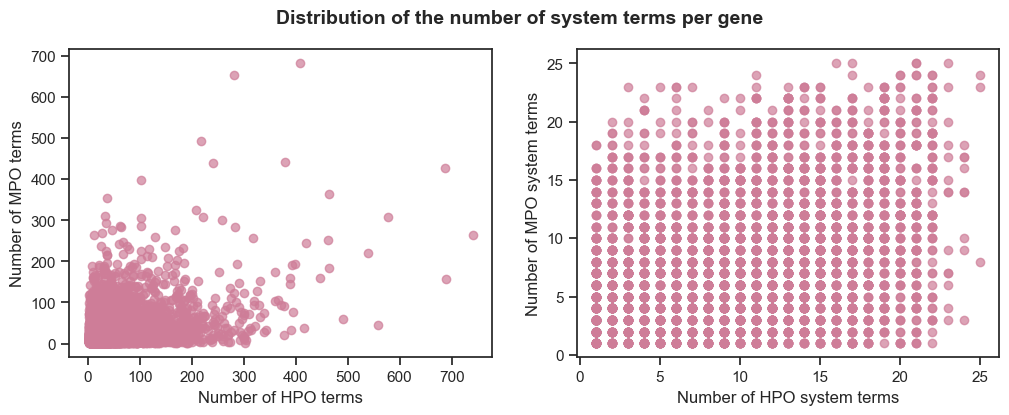

In [104]:
# look at the distribution of the number of terms and system terms per gene in mice and humans

x_low = main_HPO_table_not_na['HP_count']
y_low = main_HPO_table_not_na['MP_count']

x_high = main_HPO_table_not_na['HP_high_count']
y_high = main_HPO_table_not_na['MP_high_count']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(x_low, y_low, color='#ce7d98', alpha=0.7)
ax1.set_xlabel('Number of HPO terms')
ax1.set_ylabel('Number of MPO terms')

ax2.scatter(x_high, y_high, color='#ce7d98', alpha=0.7)
ax2.set_xlabel('Number of HPO system terms')
ax2.set_ylabel('Number of MPO system terms')

fig.suptitle('Distribution of the number of system terms per gene', fontsize=14, fontweight='bold')


plt.savefig("../pictures/plei_02_distribution_scatter.png", dpi=300)

plt.show()


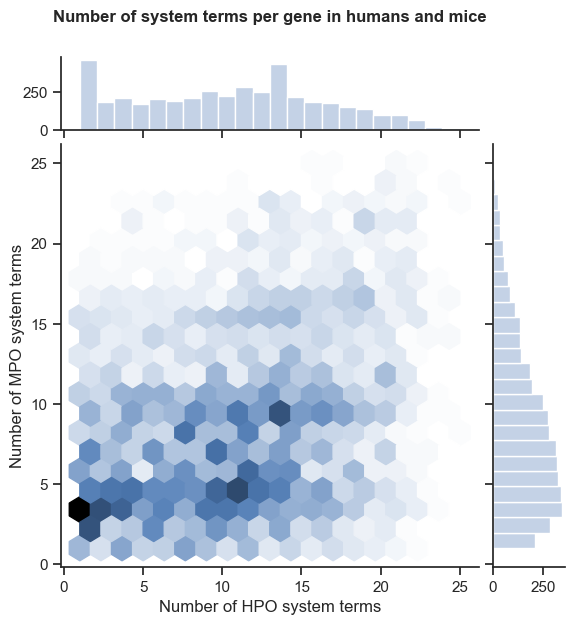

In [105]:
# look at the distribution of the number of system terms per gene in mice and humans 

sns.set_theme(style="ticks")

y_high = main_HPO_table_not_na['MP_high_count']
x_high = main_HPO_table_not_na['HP_high_count']

g = sns.jointplot(x=x_high, y=y_high, kind='hex', color="#b0c4de", gridsize=18, marginal_ticks=True)

g.set_axis_labels(xlabel='Number of HPO system terms', ylabel='Number of MPO system terms')

g.ax_joint.set_title('Number of system terms per gene in humans and mice', fontweight='bold', y=1.27)

plt.savefig("../pictures/plei_04_hexbin_high.png", dpi=300)
plt.show()

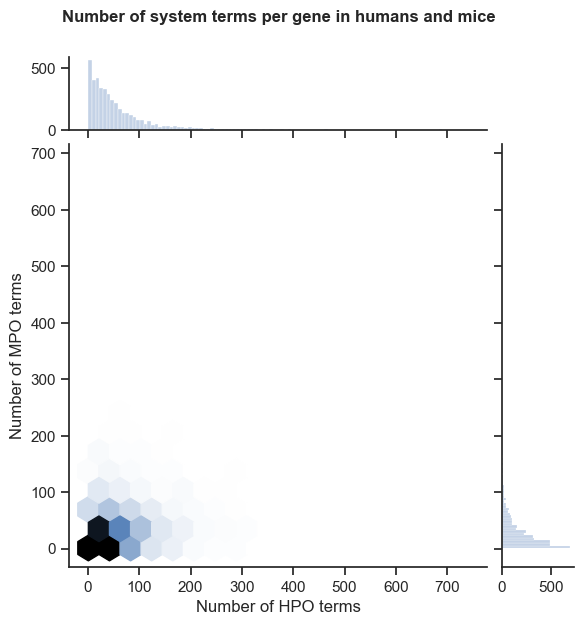

In [106]:
# look at the distribution of the number of terms per gene in mice and humans

sns.set_theme(style="ticks")

x_low = main_HPO_table_not_na['HP_count']
y_low = main_HPO_table_not_na['MP_count']

g = sns.jointplot(x=x_low, y=y_low, kind='hex', color="#b0c4de", gridsize=18, marginal_ticks=True)

g.set_axis_labels(xlabel='Number of HPO terms', ylabel='Number of MPO terms')

g.ax_joint.set_title('Number of system terms per gene in humans and mice', fontweight='bold', y=1.27)

plt.savefig("../pictures/plei_03_hexbin_low.png", dpi=300)

plt.show()

In [20]:
# find the correlation of the number of system terms

from scipy.stats import spearmanr, kendalltau

y = main_HPO_table_not_na['MP_high_count']
x = main_HPO_table_not_na['HP_high_count']

corr_k, p_value_k = kendalltau(x, y)
corr_s, p_value_s = spearmanr(x, y)

print("Kendall's tau coefficient: {:.2f}, p-value: {:.3f}".format(corr_k, p_value_k))
print("Spearman's rank correlation coefficient: {:.2f}, p-value: {:.3f}".format(corr_s, p_value_s))

Kendall's tau coefficient: 0.20, p-value: 0.000
Spearman's rank correlation coefficient: 0.28, p-value: 0.000


In [21]:
# find the correlation of the number of terms

y = main_HPO_table_not_na['MP_count']
x = main_HPO_table_not_na['HP_count']

corr_k, p_value_k = kendalltau(x, y)
corr_s, p_value_s = spearmanr(x, y)

print("Kendall's tau coefficient: {:.2f}, p-value: {:.3f}".format(corr_k, p_value_k))
print("Spearman's rank correlation coefficient: {:.2f}, p-value: {:.3f}".format(corr_s, p_value_s))

Kendall's tau coefficient: 0.18, p-value: 0.000
Spearman's rank correlation coefficient: 0.26, p-value: 0.000


### Part 5 - Split genes into several categories by eye

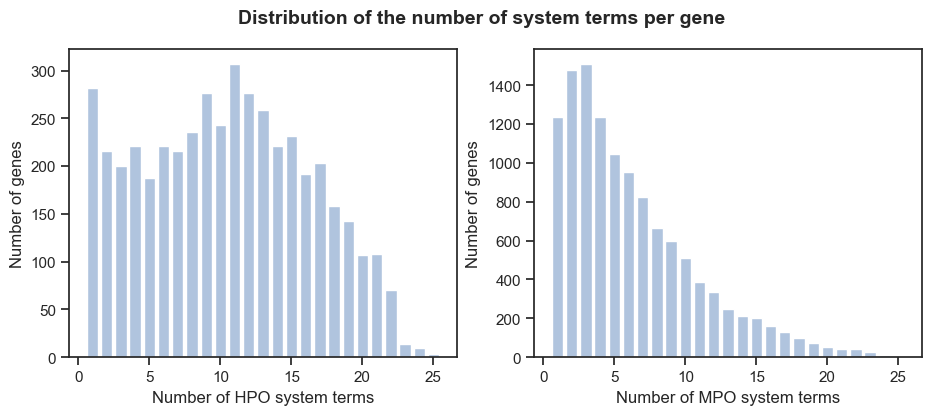

In [107]:
# looking at the distribution of the number of system terms per gene

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

# distribution of the number of system HPO terms per gene
grouped = main_HPO_table.groupby("HP_high_count")["gene_human"].count()
ax1.bar(grouped.index, grouped.values, color="#b0c4de")

ax1.set_xlabel("Number of HPO system terms")
ax1.set_ylabel("Number of genes")

# distribution of the number of system MPO terms per gene
grouped = main_HPO_table.groupby("MP_high_count")["gene_mouse"].count()
ax2.bar(grouped.index, grouped.values, color="#b0c4de")

ax2.set_xlabel("Number of MPO system terms")
ax2.set_ylabel("Number of genes")

fig.suptitle('Distribution of the number of system terms per gene', fontsize=14, fontweight='bold')

plt.savefig('../pictures/plei_05_distribution.png', dpi=300, bbox_inches='tight')

plt.show()


It seems to me that we should divide the human genes like this:
- 1 - non-pleiotropic
- 2-15 - modestly pleiotropic
- 16-41 - highly pleiotropic

And the mouse genes like this:
- 1 - non-pleiotropic
- 2-7 - modestly pleiotropic
- 8-25 - highly pleiotropic

In [23]:
# add a grouping by pleiotropy to the table

def get_pleiotropy_HPO(row):
    if row['HP_high_count'] == 1:
        return 0
    elif 2 <= row['HP_high_count'] <= 15:
        return 1
    elif 16 <= row['HP_high_count'] <= 25:
        return 2
    
def get_pleiotropy_MPO(row):
    if row['MP_high_count'] == 1:
        return 0
    elif 2 <= row['MP_high_count'] <= 7:
        return 1
    elif 8 <= row['MP_high_count'] <= 25:
        return 2

main_HPO_table['pleiotropy_HPO'] = main_HPO_table.apply(get_pleiotropy_HPO, axis=1)
main_HPO_table['pleiotropy_MPO'] = main_HPO_table.apply(get_pleiotropy_MPO, axis=1)

In [24]:
# prepare a file with genes and groups for saving

pleiotropy_group = main_HPO_table.loc[:, ["gene_human", "gene_mouse", "entrez_id_human", "MGI", "entrez_id_mouse", "pleiotropy_HPO", "pleiotropy_MPO"]].copy()
pleiotropy_group

,gene_human,gene_mouse,entrez_id_human,MGI,entrez_id_mouse,pleiotropy_HPO,pleiotropy_MPO
0,A1BG,A1bg,1,MGI:2152878,117586.0,NaN,NaN
1,A1CF,A1cf,29974,MGI:1917115,69865.0,NaN,2.0
...,...,...,...,...,...,...,...
16983,ZZEF1,Zzef1,23140,MGI:2444286,195018.0,NaN,1.0
16984,ZZZ3,Zzz3,26009,MGI:1920453,108946.0,NaN,NaN


In [25]:
# during the analysis, 4 genes disappeared, let's see which ones:
pleiotropy_group[(pleiotropy_group['entrez_id_mouse'].isna()) & (~pleiotropy_group['pleiotropy_MPO'].isna())]

,gene_human,gene_mouse,entrez_id_human,MGI,entrez_id_mouse,pleiotropy_HPO,pleiotropy_MPO
2360,CD99,Cd99,4267,MGI:1913728,NaN,NaN,1.0
2665,CHAER1,Chaer1,105377667,MGI:5624990,NaN,NaN,1.0
9153,MUC19,Muc19,283463,MGI:2676278,NaN,NaN,1.0
16141,VAMP7,Vamp7,6845,MGI:1096399,NaN,1.0,1.0


In [26]:
# add ID for genes

pleiotropy_group.loc[pleiotropy_group['entrez_id_mouse'].isna() & (pleiotropy_group['gene_mouse'] == 'Muc19'), 'entrez_id_mouse'] = 239611
pleiotropy_group.loc[pleiotropy_group['entrez_id_mouse'].isna() & (pleiotropy_group['gene_mouse'] == 'Vamp7'), 'entrez_id_mouse'] = 20955
pleiotropy_group.loc[pleiotropy_group['entrez_id_mouse'].isna() & (pleiotropy_group['gene_mouse'] == 'Chaer1'), 'entrez_id_mouse'] = 105246908
pleiotropy_group.loc[pleiotropy_group['entrez_id_mouse'].isna() & (pleiotropy_group['gene_mouse'] == 'Cd99'), 'entrez_id_mouse'] = 673094

In [27]:
# save the file with genes and groups for further analysis

pleiotropy_group.to_csv("../intermediate_data/pleiotropy_genes.csv", index=False)

In [28]:
# output the column names

pleiotropy_group.columns

Index(['gene_human', 'gene_mouse', 'entrez_id_human', 'MGI', 'entrez_id_mouse',
       'pleiotropy_HPO', 'pleiotropy_MPO'],
      dtype='object')

In [29]:
# check the size of the subsets - Human

print(pleiotropy_group[pleiotropy_group.pleiotropy_HPO == 0].shape)
print(pleiotropy_group[pleiotropy_group.pleiotropy_HPO == 1].shape)
print(pleiotropy_group[pleiotropy_group.pleiotropy_HPO == 2].shape)

(282, 7)
(3311, 7)
(1007, 7)


In [30]:
# check the size of the subsets - Mouse

print(pleiotropy_group[pleiotropy_group.pleiotropy_MPO == 0].shape)
print(pleiotropy_group[pleiotropy_group.pleiotropy_MPO == 1].shape)
print(pleiotropy_group[pleiotropy_group.pleiotropy_MPO == 2].shape)


(1235, 7)
(7042, 7)
(3821, 7)


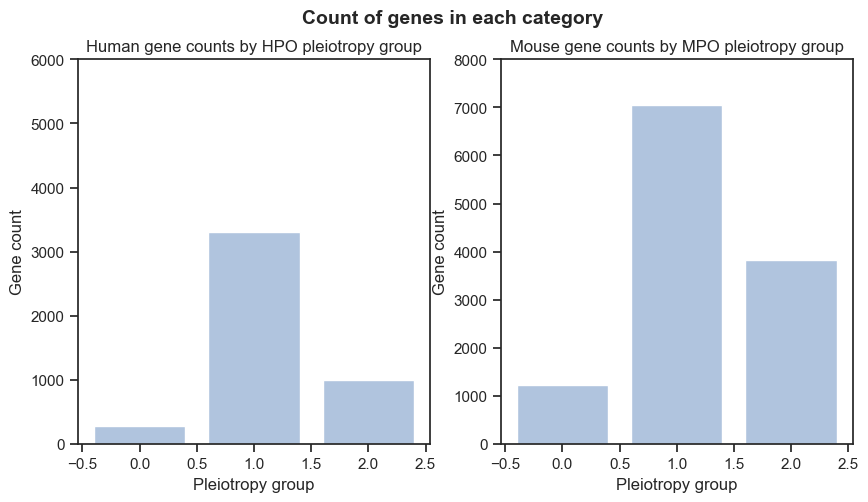

In [108]:
# bar graph in pleiotropy groups for human and mouse genes

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# human grouping: bar graph
human_gene_counts = main_HPO_table.groupby('pleiotropy_HPO')['entrez_id_human'].count()
axs[0].bar(human_gene_counts.index, human_gene_counts.values, color="#b0c4de")
axs[0].set_title('Human gene counts by HPO pleiotropy group')
axs[0].set_xlabel('Pleiotropy group')
axs[0].set_ylabel('Gene count')
axs[0].set_ylim([0, 6000]) # задаем максимальное значение по оси Y

# mouse grouping: bar graph
mouse_gene_counts = main_HPO_table.groupby('pleiotropy_MPO')['MGI'].count()
axs[1].bar(mouse_gene_counts.index, mouse_gene_counts.values, color="#b0c4de")
axs[1].set_title('Mouse gene counts by MPO pleiotropy group')
axs[1].set_xlabel('Pleiotropy group')
axs[1].set_ylabel('Gene count')
axs[1].set_ylim([0, 8000])

fig.suptitle('Count of genes in each category', fontsize=14, fontweight='bold')

plt.savefig('../pictures/plei_06_pleiotropy_groups_bar.png', dpi=300)

plt.show()

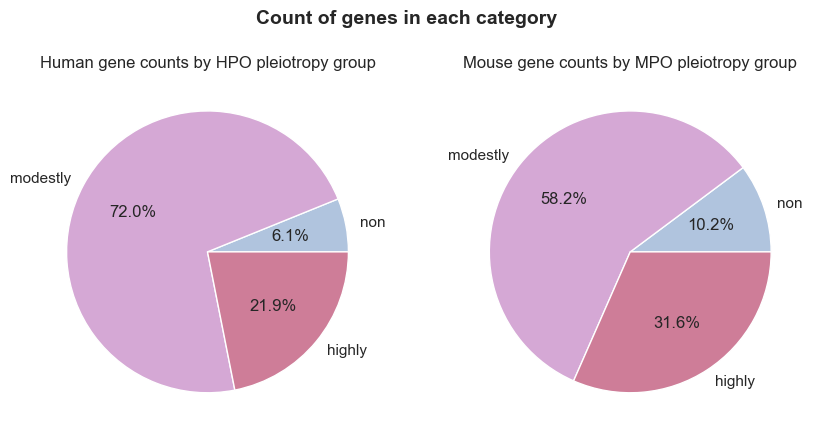

In [109]:
# pie chart in pleiotropy groups for human and mouse genes

fig, axs = plt.subplots(1, 2, figsize=(10,5))

# human grouping: pie chart
human_gene_counts = main_HPO_table.groupby('pleiotropy_HPO')['entrez_id_human'].count()
labels = ['non', 'modestly', 'highly']
colors = ['#b0c4de', '#d5a8d5', '#ce7d98']
axs[0].pie(human_gene_counts.values, labels=labels, autopct='%1.1f%%', colors=colors)
axs[0].set_title('Human gene counts by HPO pleiotropy group')

# mouse grouping: pie chart
mouse_gene_counts = main_HPO_table.groupby('pleiotropy_MPO')['MGI'].count()
labels = ['non', 'modestly', 'highly']
colors = ['#b0c4de', '#d5a8d5', '#ce7d98']
axs[1].pie(mouse_gene_counts.values, labels=labels, autopct='%1.1f%%', colors=colors)
axs[1].set_title('Mouse gene counts by MPO pleiotropy group')

fig.suptitle('Count of genes in each category', fontsize=14, fontweight='bold')

plt.savefig('../pictures/plei_07_pleiotropy_groups_pie.png', dpi=300)

plt.show()

### Part 5 - System-level terms count

In [33]:
# import ontology

from ontobio.ontol_factory import OntologyFactory

factory = OntologyFactory()

PATH_HPO = os.path.abspath("../ontologies/hpo.json")
PATH_MPO = os.path.abspath("../ontologies/mpo.json")

hpo = OntologyFactory().create(handle=PATH_HPO)
mpo = OntologyFactory().create(handle=PATH_MPO)

In [34]:
# function for switching from HP/MP term to phenotype name

def ID_to_term(terms, ontology_type):
    result = set()
    
    if ontology_type == 'hp':
        for term in terms:
            result.add(hpo.label(term))

    if ontology_type == 'mp':
        for term in terms:
            result.add(mpo.label(term))

    return tuple(result)

In [35]:
# create a new column with with the names of the system level terms

main_HPO_table['HP_name_high_level'] = main_HPO_table['HP_high_level'].apply(lambda x: ID_to_term(x, 'mp') if x is not None else None)
main_HPO_table['MP_name_high_level'] = main_HPO_table['MP_high_level'].apply(lambda x: ID_to_term(x, 'mp') if x is not None else None)

In [36]:
# output the column names

main_HPO_table.columns

Index(['gene_human', 'entrez_id_human', 'gene_mouse', 'MGI', 'entrez_id_mouse',
       'MP_low_level', 'HP_low_level', 'MP_high_level', 'HP_high_level_human',
       'HP_high_level', 'HP_count', 'HP_high_count', 'MP_count',
       'MP_high_count', 'pleiotropy_HPO', 'pleiotropy_MPO',
       'HP_name_high_level', 'MP_name_high_level'],
      dtype='object')

In [37]:
# divide the names into several lines

temp_df = main_HPO_table.explode('HP_name_high_level')
main_HPO_table_name = temp_df.explode('MP_name_high_level')

In [38]:
counts_HP_0 = main_HPO_table_name.loc[main_HPO_table_name['pleiotropy_HPO'] == 0, 'HP_name_high_level'].value_counts()
counts_HP_1 = main_HPO_table_name.loc[main_HPO_table_name['pleiotropy_HPO'] == 1, 'HP_name_high_level'].value_counts()
counts_HP_2 = main_HPO_table_name.loc[main_HPO_table_name['pleiotropy_HPO'] == 2, 'HP_name_high_level'].value_counts()
counts_MP_0 = main_HPO_table_name.loc[main_HPO_table_name['pleiotropy_MPO'] == 0, 'MP_name_high_level'].value_counts()
counts_MP_1 = main_HPO_table_name.loc[main_HPO_table_name['pleiotropy_MPO'] == 1, 'MP_name_high_level'].value_counts()
counts_MP_2 = main_HPO_table_name.loc[main_HPO_table_name['pleiotropy_MPO'] == 2, 'MP_name_high_level'].value_counts()

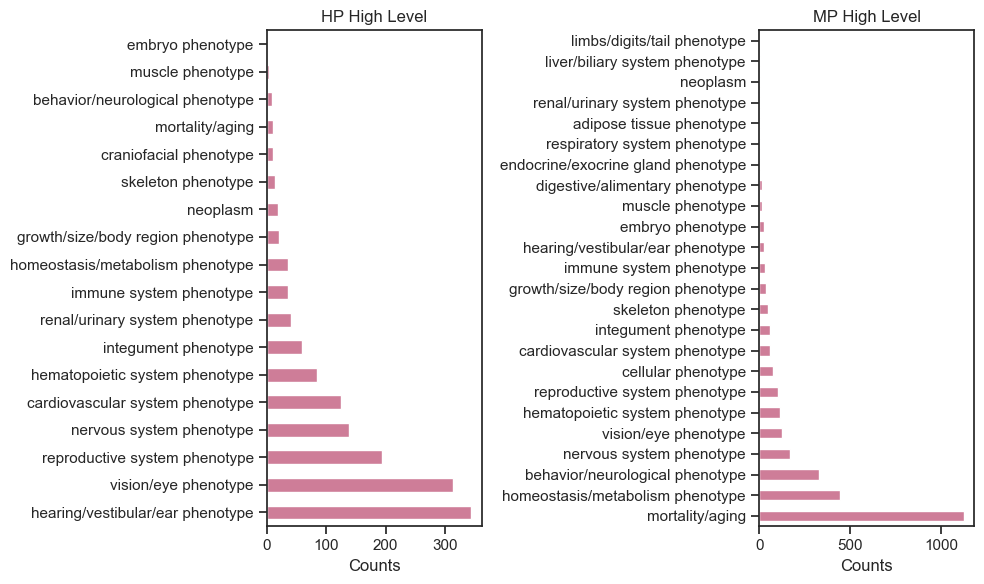

In [110]:
# non-pleiotropic, system-level terms count

fig, axs = plt.subplots(1, 2, figsize=(10, 6))

counts_HP_0.plot.barh(ax=axs[0], color='#ce7d98')
axs[0].set_title('HP High Level')
axs[0].set_xlabel('Counts')

counts_MP_0.plot.barh(ax=axs[1], color='#ce7d98')
axs[1].set_title('MP High Level')
axs[1].set_xlabel('Counts')

plt.tight_layout()

plt.savefig('../pictures/plei_08_terms_for_non.png', dpi=300)

plt.show()

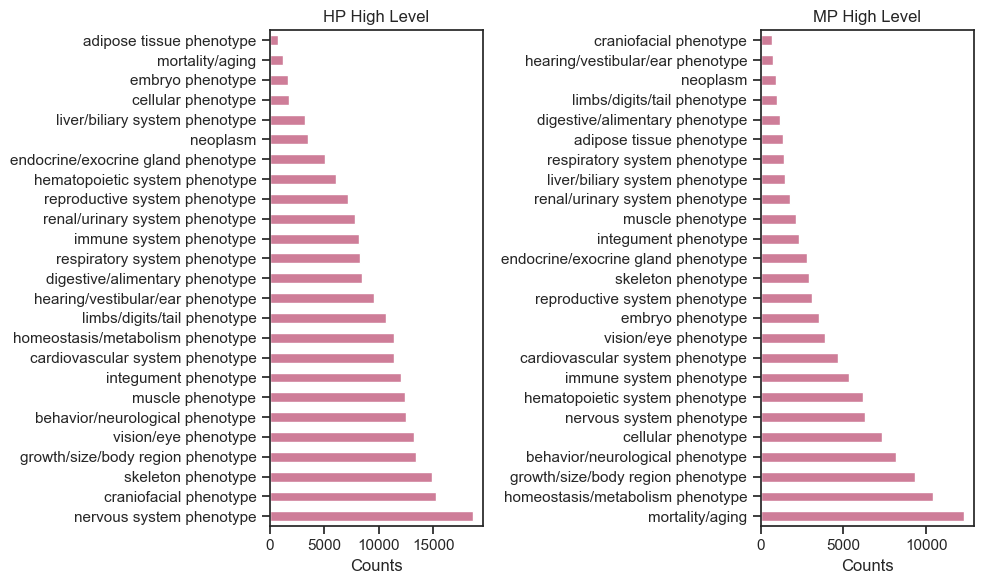

In [111]:
# modestly-pleiotropic, system-level terms count

fig, axs = plt.subplots(1, 2, figsize=(10, 6))

counts_HP_1.plot.barh(ax=axs[0], color='#ce7d98')
axs[0].set_title('HP High Level')
axs[0].set_xlabel('Counts')

counts_MP_1.plot.barh(ax=axs[1], color='#ce7d98')
axs[1].set_title('MP High Level')
axs[1].set_xlabel('Counts')

plt.tight_layout()

plt.savefig('../pictures/plei_09_terms_for_modestly.png', dpi=300)

plt.show()

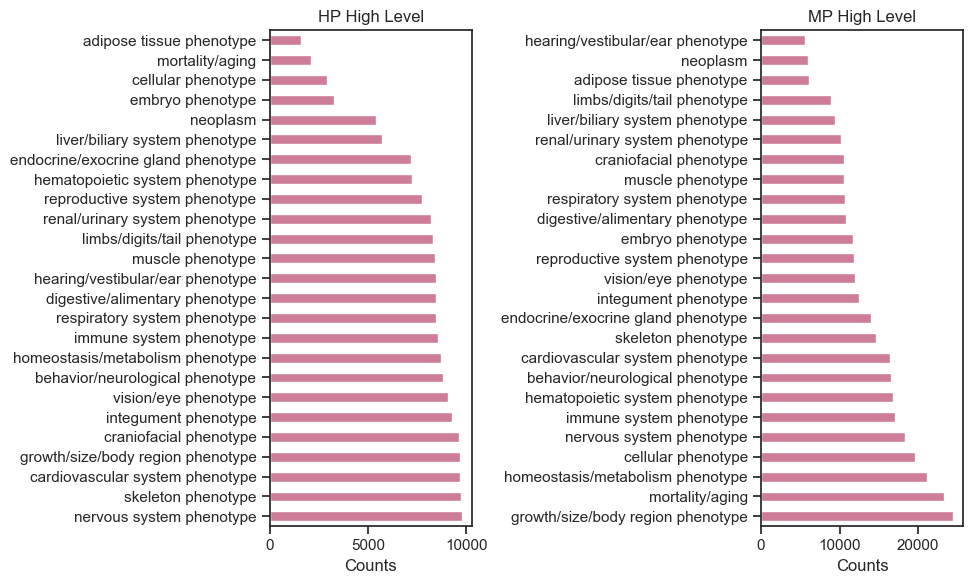

In [41]:
# highly-pleiotropic, system-level terms count

fig, axs = plt.subplots(1, 2, figsize=(10, 6))

counts_HP_2.plot.barh(ax=axs[0], color='#ce7d98')
axs[0].set_title('HP High Level')
axs[0].set_xlabel('Counts')

counts_MP_2.plot.barh(ax=axs[1], color='#ce7d98')
axs[1].set_title('MP High Level')
axs[1].set_xlabel('Counts')

plt.tight_layout()

plt.savefig('../pictures/plei_10_terms_for_highly.png', dpi=300)

plt.show()

### Part 6 - Add expression levels and compare them (using GTEx data)

In [42]:
# importing the GTEx table

gtex_data = pd.read_csv("../databases/expression_GTEx.gct",
                   delimiter='\t',
                   skiprows=2)
gtex_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56200 entries, 0 to 56199
Data columns (total 56 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Name                                       56200 non-null  object 
 1   Description                                56200 non-null  object 
 2   Adipose - Subcutaneous                     56200 non-null  float64
 3   Adipose - Visceral (Omentum)               56200 non-null  float64
 4   Adrenal Gland                              56200 non-null  float64
 5   Artery - Aorta                             56200 non-null  float64
 6   Artery - Coronary                          56200 non-null  float64
 7   Artery - Tibial                            56200 non-null  float64
 8   Bladder                                    56200 non-null  float64
 9   Brain - Amygdala                           56200 non-null  float64
 10  Brain - Anterior cingu

In [43]:
# adding new columns with median and average tissue expression 
gtex_data['median_exp'] = gtex_data.iloc[:, 2:55].median(axis=1)
gtex_data['mean_exp'] = gtex_data.iloc[:, 2:55].mean(axis=1)

# add new columns with the number of tissues with expression > 10
gtex_data['count_exp'] = gtex_data.iloc[:, 2:55].apply(lambda x: (x > 10).sum(), axis=1)

In [44]:
# merge the dataframes gtex_data and main_HPO_table

merged_expr = main_HPO_table.merge(gtex_data, how='left', left_on='gene_human', right_on='Description')
merged_expr = merged_expr.loc[:, ['gene_human', 'entrez_id_human', 'gene_mouse', 'MGI', 'entrez_id_mouse',
                                  'MP_low_level', 'HP_low_level', 'MP_high_level', 'HP_high_level_human',
                                  'HP_high_level', 'HP_count', 'HP_high_count', 'MP_count', 'MP_high_count', 
                                  'pleiotropy_HPO', 'pleiotropy_MPO', 'HP_name_high_level', 'MP_name_high_level', 
                                  'median_exp', 'mean_exp', 'count_exp']]

In [45]:
#  look at the duplicates

duplicates = merged_expr[merged_expr.duplicated(subset=['gene_human', 'gene_mouse'], keep=False)]
print(len(duplicates))

49


In [46]:
# remove duplicates

duplicates = merged_expr[merged_expr.duplicated(subset=['gene_human', 'gene_mouse'], keep=False)]

# remove duplicates with 0 expression related to _PAR_Y

for index, row in duplicates.iterrows():
    if (row['median_exp'] == 0) and (row['mean_exp'] == 0) and (row['count_exp'] == 0):
        merged_expr = merged_expr.drop(index)

# delete all duplicates with double ENSG

merged_expr.drop_duplicates(subset=['gene_human', 'gene_mouse'], keep=False, inplace=True)


In [47]:
#  look at the duplicates (again)

duplicates = merged_expr[merged_expr.duplicated(subset=['gene_human', 'gene_mouse'], keep=False)]
print(len(duplicates))

0


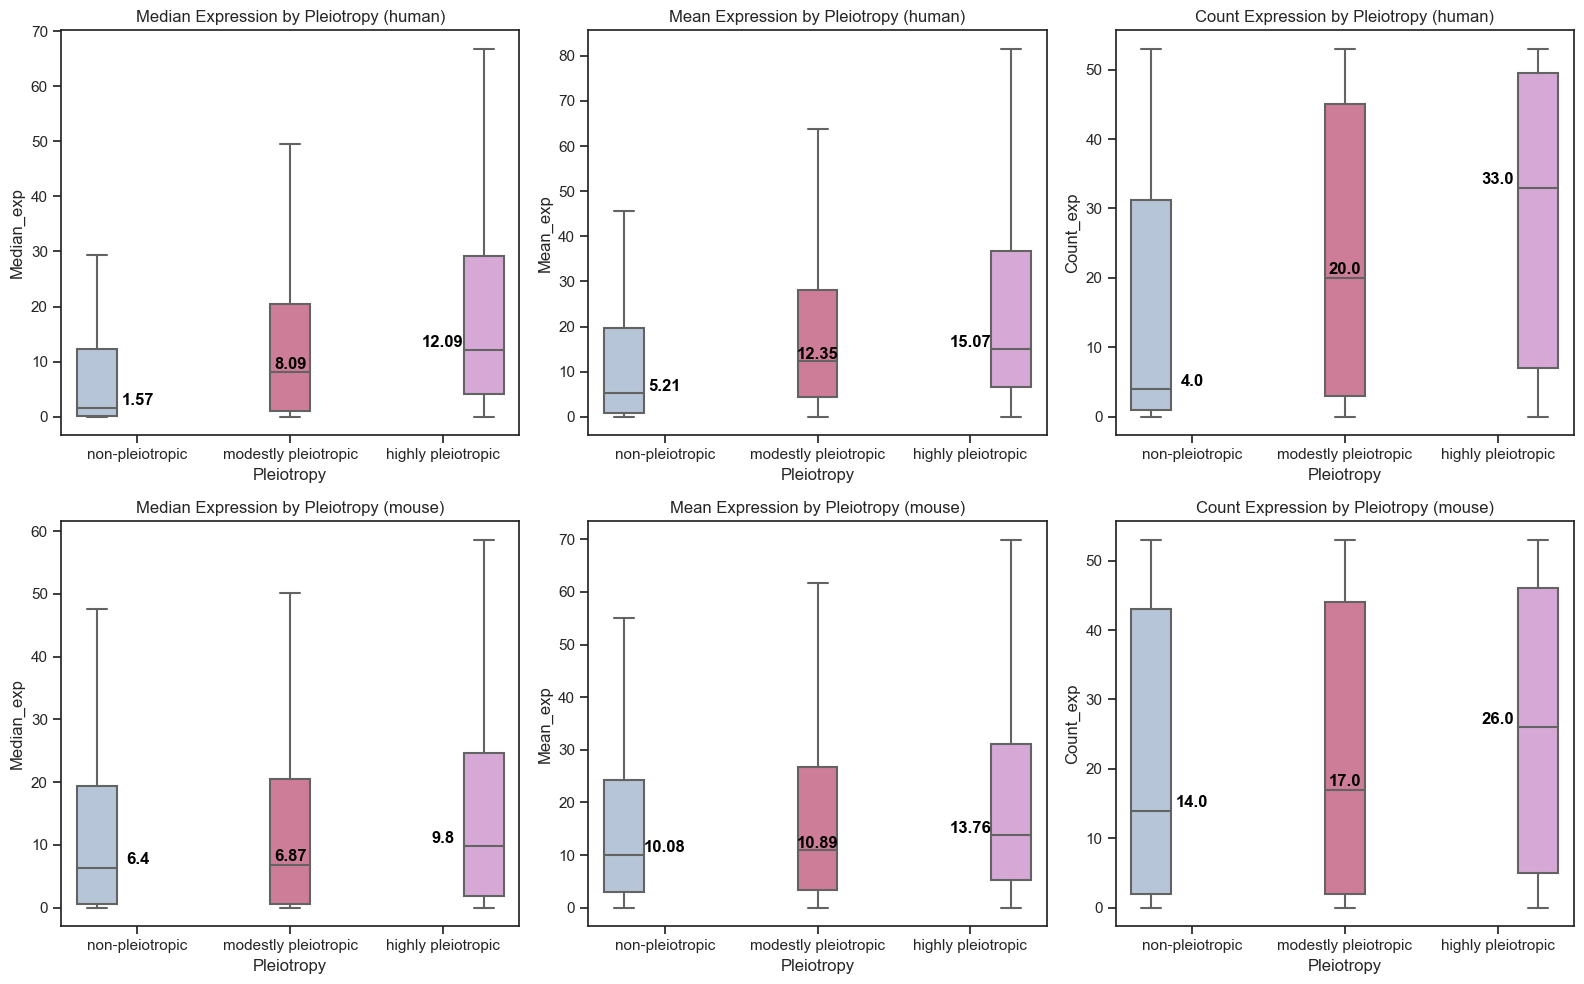

In [48]:
# visualize the expression level in pleiotropy groups for human and mouse genes
palette_groups = sns.color_palette(["lightsteelblue", "palevioletred", "plum", "pink", "lavender", "thistle", "lightblue", "navy"])

merged_expr['ply_HPO'] = merged_expr['pleiotropy_HPO'].replace({0.0: 'non-pleiotropic', 1.0: 'modestly pleiotropic', 2.0: 'highly pleiotropic'}).astype('category')
cat_ply_HPO = merged_expr['ply_HPO'].cat.reorder_categories(['non-pleiotropic', 'modestly pleiotropic', 'highly pleiotropic'])
merged_expr['ply_HPO'] = cat_ply_HPO

merged_expr['ply_MPO'] = merged_expr['pleiotropy_MPO'].replace({0.0: 'non-pleiotropic', 1.0: 'modestly pleiotropic', 2.0: 'highly pleiotropic'}).astype('category')
cat_ply_MPO = merged_expr['ply_MPO'].cat.reorder_categories(['non-pleiotropic', 'modestly pleiotropic', 'highly pleiotropic'])
merged_expr['ply_MPO'] = cat_ply_MPO


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))

datasets = [{'x': 'ply_HPO', 'y': 'median_exp', 'hue': 'ply_HPO', 'title': 'Median Expression by Pleiotropy (human)'},
            {'x': 'ply_HPO', 'y': 'mean_exp', 'hue': 'ply_HPO', 'title': 'Mean Expression by Pleiotropy (human)'},
            {'x': 'ply_HPO', 'y': 'count_exp', 'hue': 'ply_HPO', 'title': 'Count Expression by Pleiotropy (human)'},
            {'x': 'ply_MPO', 'y': 'median_exp', 'hue': 'ply_MPO', 'title': 'Median Expression by Pleiotropy (mouse)'},
            {'x': 'ply_MPO', 'y': 'mean_exp', 'hue': 'ply_MPO', 'title': 'Mean Expression by Pleiotropy (mouse)'},
            {'x': 'ply_MPO', 'y': 'count_exp', 'hue': 'ply_MPO', 'title': 'Count Expression by Pleiotropy (mouse)'}]

for i, ax in enumerate(axes.flat):
    data = datasets[i]
    sns.boxplot(ax=ax, x=data['x'], y=data['y'], hue=data['hue'], data=merged_expr, showfliers=False, palette=palette_groups)
    ax.set_xlabel('Pleiotropy')
    ax.set_ylabel(data['y'].capitalize())
    ax.set_title(data['title'])
    ax.legend().set_visible(False)

    medians = merged_expr.groupby(data['x'])[data['y']].median().values
    median_labels = [str(np.round(s, 2)) for s in medians]

    pos = range(len(medians))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 0.5, median_labels[tick], 
                horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.tight_layout()

plt.savefig('../pictures/plei_11_expression_level.png', dpi=300)

plt.show()


In [49]:
merged_expr = merged_expr.loc[:, ['gene_human', 'entrez_id_human', 'gene_mouse', 'MGI', 'entrez_id_mouse',
                                  'MP_low_level', 'HP_low_level', 'MP_high_level', 'HP_high_level_human',
                                  'HP_high_level', 'HP_count', 'HP_high_count', 'MP_count',
                                  'MP_high_count', 'pleiotropy_HPO', 'pleiotropy_MPO',
                                  'HP_name_high_level', 'MP_name_high_level', 'median_exp', 'mean_exp',
                                  'count_exp']].copy()

In [50]:
# save the file with expression in pleiotropy groups

expression = merged_expr.loc[:, ["entrez_id_human", 'entrez_id_mouse', "pleiotropy_HPO", "pleiotropy_MPO", "median_exp", "mean_exp", "count_exp"]].copy()
expression.to_csv("../intermediate_data/expression.csv", index=False)

In [51]:
# calculate outlier for median_exp column

outlier_limits_h = {}
outlier_limits_m = {}

for hpo in [0, 1, 2]:
    Q1_h = merged_expr.loc[(merged_expr['pleiotropy_HPO'] == hpo), 'median_exp'].quantile(0.25)
    Q3_h = merged_expr.loc[(merged_expr['pleiotropy_HPO'] == hpo), 'median_exp'].quantile(0.75)

    outlier_limits_h[hpo] = (Q1_h, Q3_h)
    
for mpo in [0, 1, 2]:
    Q1_m = merged_expr.loc[(merged_expr['pleiotropy_MPO'] == mpo), 'median_exp'].quantile(0.25)
    Q3_m = merged_expr.loc[(merged_expr['pleiotropy_MPO'] == mpo), 'median_exp'].quantile(0.75)

    outlier_limits_m[mpo] = (Q1_m, Q3_m)


merged_expr['outlier_median_exp_h'] = 0
merged_expr['outlier_median_exp_m'] = 0


for hpo, limits in outlier_limits_h.items():
    merged_expr.loc[(merged_expr['pleiotropy_HPO'] == hpo) & (merged_expr['median_exp'] < limits[0]), 'outlier_median_exp_h'] = -1
    merged_expr.loc[(merged_expr['pleiotropy_HPO'] == hpo) & (merged_expr['median_exp'] > limits[1]), 'outlier_median_exp_h'] = 1


for mpo, limits in outlier_limits_m.items():
    merged_expr.loc[(merged_expr['pleiotropy_MPO'] == mpo) & (merged_expr['median_exp'] < limits[0]), 'outlier_median_exp_m'] = -1
    merged_expr.loc[(merged_expr['pleiotropy_MPO'] == mpo) & (merged_expr['median_exp'] > limits[1]), 'outlier_median_exp_m'] = 1

In [52]:
# calculate outlier for mean_exp column
outlier_limits_h = {}
outlier_limits_m = {}

for hpo in [0, 1, 2]:
    Q1_h = merged_expr.loc[(merged_expr['pleiotropy_HPO'] == hpo), 'mean_exp'].quantile(0.25)
    Q3_h = merged_expr.loc[(merged_expr['pleiotropy_HPO'] == hpo), 'mean_exp'].quantile(0.75)

    outlier_limits_h[hpo] = (Q1_h, Q3_h)
    
for mpo in [0, 1, 2]:
    Q1_m = merged_expr.loc[(merged_expr['pleiotropy_MPO'] == mpo), 'mean_exp'].quantile(0.25)
    Q3_m = merged_expr.loc[(merged_expr['pleiotropy_MPO'] == mpo), 'mean_exp'].quantile(0.75)

    outlier_limits_m[mpo] = (Q1_m, Q3_m)


merged_expr['outlier_mean_exp_h'] = 0
merged_expr['outlier_mean_exp_m'] = 0


for hpo, limits in outlier_limits_h.items():
    merged_expr.loc[(merged_expr['pleiotropy_HPO'] == hpo) & (merged_expr['mean_exp'] < limits[0]), 'outlier_mean_exp_h'] = -1
    merged_expr.loc[(merged_expr['pleiotropy_HPO'] == hpo) & (merged_expr['mean_exp'] > limits[1]), 'outlier_mean_exp_h'] = 1


for mpo, limits in outlier_limits_m.items():
    merged_expr.loc[(merged_expr['pleiotropy_MPO'] == mpo) & (merged_expr['mean_exp'] < limits[0]), 'outlier_mean_exp_m'] = -1
    merged_expr.loc[(merged_expr['pleiotropy_MPO'] == mpo) & (merged_expr['mean_exp'] > limits[1]), 'outlier_mean_exp_m'] = 1

In [53]:
# calculate outlier for count_exp column
outlier_limits_h = {}
outlier_limits_m = {}

for hpo in [0, 1, 2]:
    Q1_h = merged_expr.loc[(merged_expr['pleiotropy_HPO'] == hpo), 'count_exp'].quantile(0.25)
    Q3_h = merged_expr.loc[(merged_expr['pleiotropy_HPO'] == hpo), 'count_exp'].quantile(0.75)

    outlier_limits_h[hpo] = (Q1_h, Q3_h)
    
for mpo in [0, 1, 2]:
    Q1_m = merged_expr.loc[(merged_expr['pleiotropy_MPO'] == mpo), 'count_exp'].quantile(0.25)
    Q3_m = merged_expr.loc[(merged_expr['pleiotropy_MPO'] == mpo), 'count_exp'].quantile(0.75)

    outlier_limits_m[mpo] = (Q1_m, Q3_m)


merged_expr['outlier_count_exp_h'] = 0
merged_expr['outlier_count_exp_m'] = 0


for hpo, limits in outlier_limits_h.items():
    merged_expr.loc[(merged_expr['pleiotropy_HPO'] == hpo) & (merged_expr['count_exp'] < limits[0]), 'outlier_count_exp_h'] = -1
    merged_expr.loc[(merged_expr['pleiotropy_HPO'] == hpo) & (merged_expr['count_exp'] > limits[1]), 'outlier_count_exp_h'] = 1

for mpo, limits in outlier_limits_m.items():
    merged_expr.loc[(merged_expr['pleiotropy_MPO'] == mpo) & (merged_expr['count_exp'] < limits[0]), 'outlier_count_exp_m'] = -1
    merged_expr.loc[(merged_expr['pleiotropy_MPO'] == mpo) & (merged_expr['count_exp'] > limits[1]), 'outlier_count_exp_m'] = 1

In [54]:
# check the size of the subsets - Human

print(merged_expr[(merged_expr['pleiotropy_HPO'] == 0) & (merged_expr['outlier_median_exp_h'] == 1)].shape)
print(merged_expr[(merged_expr['pleiotropy_HPO'] == 0) & (merged_expr['outlier_mean_exp_h'] == 1)].shape)
print(merged_expr[(merged_expr['pleiotropy_HPO'] == 0) & (merged_expr['outlier_count_exp_h'] == 1)].shape)


(69, 27)
(69, 27)
(69, 27)


In [55]:
# check the size of the subsets - Human

print(merged_expr[(merged_expr['pleiotropy_HPO'] == 2) & (merged_expr['outlier_median_exp_h'] == -1)].shape)
print(merged_expr[(merged_expr['pleiotropy_HPO'] == 2) & (merged_expr['outlier_mean_exp_h'] == -1)].shape)
print(merged_expr[(merged_expr['pleiotropy_HPO'] == 2) & (merged_expr['outlier_count_exp_h'] == -1)].shape)

(241, 27)
(241, 27)
(232, 27)


In [56]:
# check the size of the subsets - Mouse

print(merged_expr[(merged_expr['pleiotropy_MPO'] == 0) & (merged_expr['outlier_median_exp_m'] == 1)].shape)
print(merged_expr[(merged_expr['pleiotropy_MPO'] == 0) & (merged_expr['outlier_mean_exp_m'] == 1)].shape)
print(merged_expr[(merged_expr['pleiotropy_MPO'] == 0) & (merged_expr['outlier_count_exp_m'] == 1)].shape)

(294, 27)
(294, 27)
(289, 27)


In [57]:
# check the size of the subsets - Mouse

print(merged_expr[(merged_expr['pleiotropy_MPO'] == 2) & (merged_expr['outlier_median_exp_m'] == -1)].shape)
print(merged_expr[(merged_expr['pleiotropy_MPO'] == 2) & (merged_expr['outlier_mean_exp_m'] == -1)].shape)
print(merged_expr[(merged_expr['pleiotropy_MPO'] == 2) & (merged_expr['outlier_count_exp_m'] == -1)].shape)

(935, 27)
(935, 27)
(921, 27)


In [61]:
# prepare data for emission estimation

# leave only the necessary columns
merged_expr = merged_expr.loc[:, ['gene_human', 'gene_mouse', 'entrez_id_mouse', 'MP_high_level', 'HP_high_level', 
                                  'pleiotropy_HPO', 'pleiotropy_MPO', 'HP_name_high_level', 'MP_name_high_level',
                                  'count_exp']].copy()


# add the required columns to indicate the outliers
merged_expr.loc[(merged_expr['pleiotropy_HPO'] == 0) & (merged_expr['count_exp'] > 31.25), 'out_count_HP'] = 1
merged_expr.loc[(merged_expr['pleiotropy_HPO'] == 0) & (merged_expr['count_exp'] <= 31.25), 'out_count_HP'] = 0

merged_expr.loc[(merged_expr['pleiotropy_MPO'] == 0) & (merged_expr['count_exp'] > 43), 'out_count_MP'] = 1
merged_expr.loc[(merged_expr['pleiotropy_MPO'] == 0) & (merged_expr['count_exp'] <= 43), 'out_count_MP'] = 0

merged_expr.loc[(merged_expr['pleiotropy_HPO'] == 2) & (merged_expr['count_exp'] < 7), 'out_count_HP_2'] = 1
merged_expr.loc[(merged_expr['pleiotropy_HPO'] == 2) & (merged_expr['count_exp'] >= 7), 'out_count_HP_2'] = 0

merged_expr.loc[(merged_expr['pleiotropy_MPO'] == 2) & (merged_expr['count_exp'] < 5), 'out_count_MP_2'] = 1
merged_expr.loc[(merged_expr['pleiotropy_MPO'] == 2) & (merged_expr['count_exp'] >= 5), 'out_count_MP_2'] = 0

In [81]:
# create a new "long" data frame for human, non-pleiotropic

merged_expr_filtered = merged_expr[merged_expr['pleiotropy_HPO'] == 0]
merged_expr_filtered = merged_expr_filtered.explode('HP_name_high_level')

grouped = merged_expr_filtered.groupby(['HP_name_high_level', 'out_count_HP']).agg({'gene_human': 'nunique'})
grouped.columns = ['gene_count']

out_count_HP_0 = grouped.reset_index().pivot(index='HP_name_high_level', columns='out_count_HP', values='gene_count')
out_count_HP_0.columns = ['gene_count_0', 'gene_count_1']
out_count_HP_0 = out_count_HP_0.reset_index()
out_count_HP_0.columns = ['HP', 'gene_count_0', 'gene_count_1']

out_count_HP_0 = out_count_HP_0.melt(id_vars=['HP'], var_name='out', value_name='gene_count')
out_count_HP_0 = out_count_HP_0.replace({'gene_count_0': 0, 'gene_count_1': 1})
out_count_HP_0.columns = ['HP', 'out', 'gene_count']
out_count_HP_0["out"].replace({0: "min-Q3", 1: ">Q3"}, inplace=True)

out_count_HP_0.to_csv("../intermediate_data/out_count_HP_0.csv", index=False)

In [82]:
# create a new "long" data frame for mouse, non-pleiotropic

merged_expr_filtered = merged_expr[merged_expr['pleiotropy_MPO'] == 0]
merged_expr_filtered = merged_expr_filtered.explode('MP_name_high_level')

grouped = merged_expr_filtered.groupby(['MP_name_high_level', 'out_count_MP']).agg({'gene_mouse': 'nunique'})
grouped.columns = ['gene_count']

out_count_MP_0 = grouped.reset_index().pivot(index='MP_name_high_level', columns='out_count_MP', values='gene_count')
out_count_MP_0.columns = ['gene_count_0', 'gene_count_1']
out_count_MP_0 = out_count_MP_0.reset_index()
out_count_MP_0.columns = ['MP', 'gene_count_0', 'gene_count_1']

out_count_MP_0 = out_count_MP_0.melt(id_vars=['MP'], var_name='out', value_name='gene_count')
out_count_MP_0 = out_count_MP_0.replace({'gene_count_0': 0, 'gene_count_1': 1})
out_count_MP_0.columns = ['MP', 'out', 'gene_count']
out_count_MP_0["out"].replace({0: "min-Q3", 1: ">Q3"}, inplace=True)

out_count_MP_0.to_csv("../intermediate_data/out_count_MP_0.csv", index=False)

In [83]:
# create a new "long" data frame for human, highly-pleiotropic

merged_expr_filtered = merged_expr[merged_expr['pleiotropy_HPO'] == 2]
merged_expr_filtered = merged_expr_filtered.explode('HP_name_high_level')

grouped = merged_expr_filtered.groupby(['HP_name_high_level', 'out_count_HP_2']).agg({'gene_human': 'nunique'})
grouped.columns = ['gene_count']

out_count_HP_2 = grouped.reset_index().pivot(index='HP_name_high_level', columns='out_count_HP_2', values='gene_count')
out_count_HP_2.columns = ['gene_count_0', 'gene_count_1']
out_count_HP_2 = out_count_HP_2.reset_index()
out_count_HP_2.columns = ['HP', 'gene_count_0', 'gene_count_1']

out_count_HP_2 = out_count_HP_2.melt(id_vars=['HP'], var_name='out', value_name='gene_count')
out_count_HP_2 = out_count_HP_2.replace({'gene_count_0': 0, 'gene_count_1': 1})
out_count_HP_2.columns = ['HP', 'out', 'gene_count']
out_count_HP_2["out"].replace({0: "Q1-max", 1: "<Q1"}, inplace=True)

out_count_HP_2.to_csv("../intermediate_data/out_count_HP_2.csv", index=False)

In [84]:
# create a new "long" data frame for mouse, highly-pleiotropic

merged_expr_filtered = merged_expr[merged_expr['pleiotropy_MPO'] == 2]
merged_expr_filtered = merged_expr_filtered.explode('MP_name_high_level')

grouped = merged_expr_filtered.groupby(['MP_name_high_level', 'out_count_MP_2']).agg({'gene_mouse': 'nunique'})
grouped.columns = ['gene_count']

out_count_MP_2 = grouped.reset_index().pivot(index='MP_name_high_level', columns='out_count_MP_2', values='gene_count')
out_count_MP_2.columns = ['gene_count_0', 'gene_count_1']
out_count_MP_2 = out_count_MP_2.reset_index()
out_count_MP_2.columns = ['MP', 'gene_count_0', 'gene_count_1']

out_count_MP_2 = out_count_MP_2.melt(id_vars=['MP'], var_name='out', value_name='gene_count')
out_count_MP_2 = out_count_MP_2.replace({'gene_count_0': 0, 'gene_count_1': 1})
out_count_MP_2.columns = ['MP', 'out', 'gene_count']
out_count_MP_2["out"].replace({0: "Q1-max", 1: "<Q1"}, inplace=True)

out_count_MP_2.to_csv("../intermediate_data/out_count_MP_2.csv", index=False)

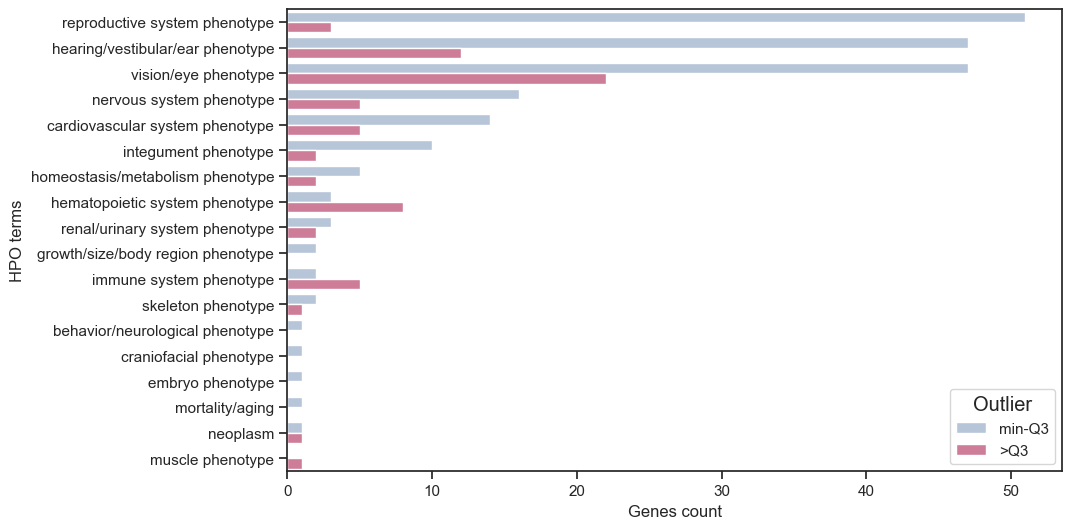

In [66]:
plt.figure(figsize=(10, 6))

out_count_HP_0 = out_count_HP_0.sort_values(["out", "gene_count"], ascending=[False, False])

sns.barplot(data=out_count_HP_0, y="HP", x="gene_count", hue="out", palette=palette_groups)
plt.xlabel('Genes count')
plt.ylabel('HPO terms')
plt.legend(title="Outlier", title_fontsize="large", loc='lower right')

plt.savefig('../pictures/plei_12_out_human_0_count.png', dpi=300, bbox_inches='tight')

plt.show()

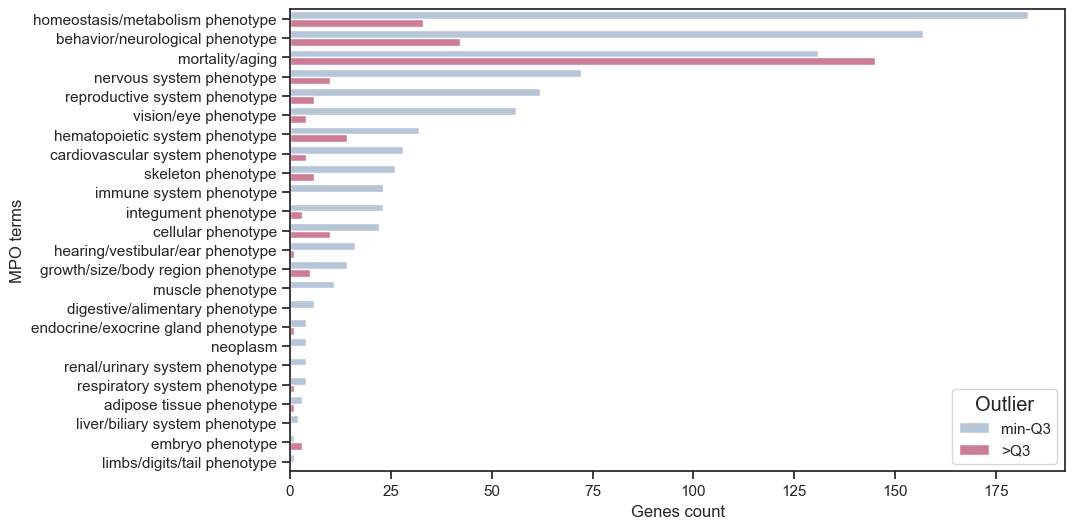

In [67]:
plt.figure(figsize=(10, 6))

out_count_MP_0 = out_count_MP_0.sort_values(["out", "gene_count"], ascending=[False, False])

sns.barplot(data=out_count_MP_0, y="MP", x="gene_count", hue="out", palette=palette_groups)
plt.xlabel('Genes count')
plt.ylabel('MPO terms')
plt.legend(title="Outlier", title_fontsize="large", loc='lower right')

plt.savefig('../pictures/plei_13_out_mouse_0_count.png', dpi=300, bbox_inches='tight')

plt.show()

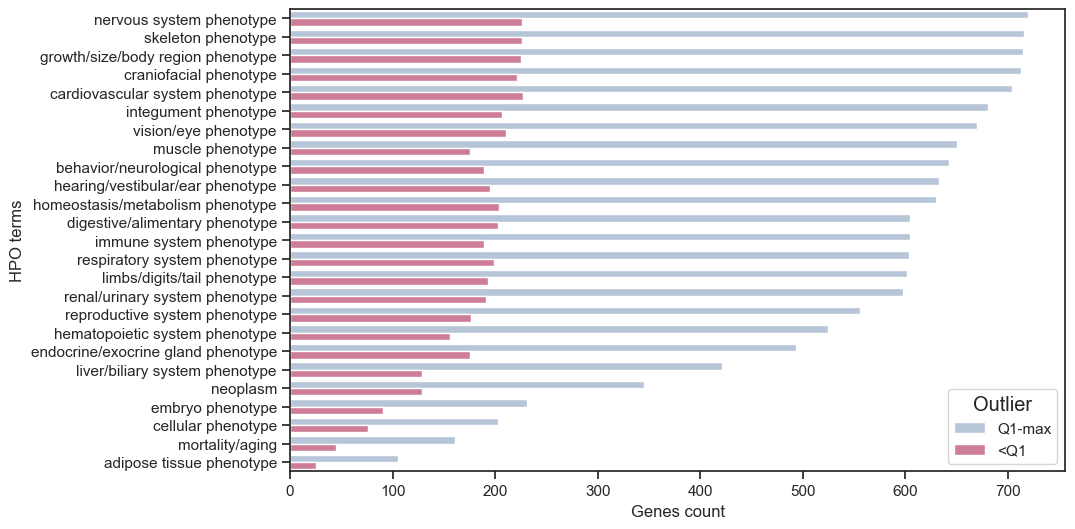

In [68]:
plt.figure(figsize=(10, 6))

out_count_HP_2 = out_count_HP_2.sort_values(["out", "gene_count"], ascending=[False, False])

sns.barplot(data=out_count_HP_2, y="HP", x="gene_count", hue="out", palette=palette_groups)
plt.xlabel('Genes count')
plt.ylabel('HPO terms')
plt.legend(title="Outlier", title_fontsize="large", loc='lower right')

plt.savefig('../pictures/plei_14_out_human_2_count.png', dpi=300, bbox_inches='tight')

plt.show()

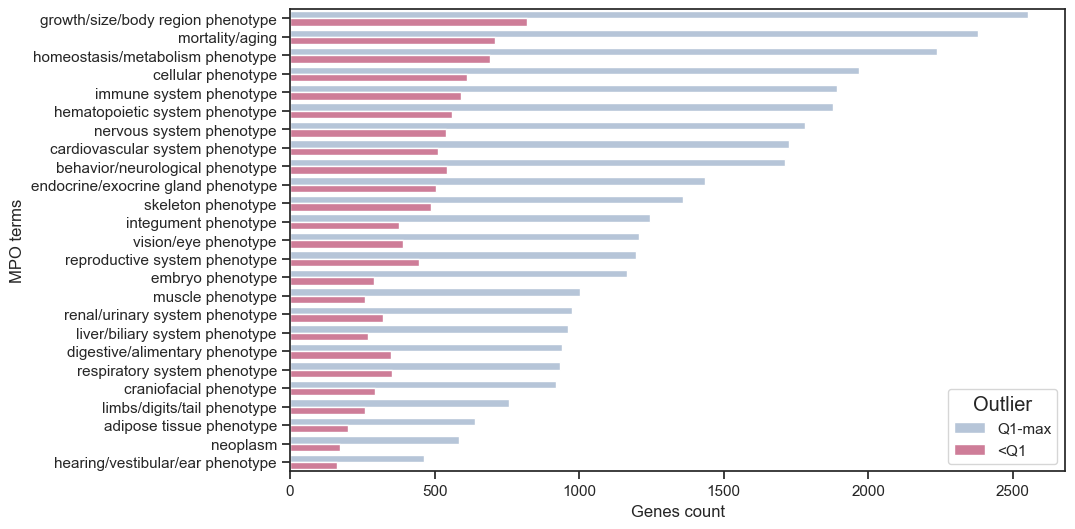

In [69]:
plt.figure(figsize=(10, 6))

out_count_MP_2 = out_count_MP_2.sort_values(["out", "gene_count"], ascending=[False, False])

sns.barplot(data=out_count_MP_2, y="MP", x="gene_count", hue="out", palette=palette_groups)
plt.xlabel('Genes count')
plt.ylabel('MPO terms')
plt.legend(title="Outlier", title_fontsize="large", loc='lower right')

plt.savefig('../pictures/plei_15_out_mouse_2_count.png', dpi=300, bbox_inches='tight')

plt.show()

In [70]:
# create a dataframe with the number of tissues being expressed

expr_tissue = gtex_data
expr_tissue[expr_tissue.columns[2:56]] = expr_tissue[expr_tissue.columns[2:56]].apply(lambda x: x.apply(lambda y: 1 if y > 10 else 0))
expr_tissue = expr_tissue.drop(['Name', 'median_exp', 'mean_exp', 'count_exp'], axis=1)

In [71]:
# create a dataframe with genes that are expressed in a small number of tissues, human

gene_tissue_human_out = merged_expr[(merged_expr['pleiotropy_HPO'] == 2) & (merged_expr['out_count_HP_2'] == 1)]
gene_tissue_human_out = gene_tissue_human_out.loc[:, ['gene_human']].copy()

gene_tissue_human_not_out = merged_expr[(merged_expr['pleiotropy_HPO'] == 2) & (merged_expr['out_count_HP_2'] == 0)]
gene_tissue_human_not_out = gene_tissue_human_not_out.loc[:, ['gene_human']].copy()

In [72]:
# create a dataframe with genes that are expressed in a small number of tissues, mouse

gene_tissue_mouse_out = merged_expr[(merged_expr['pleiotropy_MPO'] == 2) & (merged_expr['out_count_MP_2'] == 1)]
gene_tissue_mouse_out = gene_tissue_mouse_out.loc[:, ['gene_human', 'gene_mouse']].copy()

gene_tissue_mouse_not_out = merged_expr[(merged_expr['pleiotropy_MPO'] == 2) & (merged_expr['out_count_MP_2'] == 0)]
gene_tissue_mouse_not_out = gene_tissue_mouse_not_out.loc[:, ['gene_human', 'gene_mouse']].copy()

In [73]:
# merge gene_tissue and expr_tissue, human

merged_tissue_human_out = gene_tissue_human_out.merge(expr_tissue, how='left', left_on='gene_human', right_on='Description')
merged_tissue_human_out = merged_tissue_human_out.drop(['Description'], axis=1)

merged_tissue_human_not_out = gene_tissue_human_not_out.merge(expr_tissue, how='left', left_on='gene_human', right_on='Description')
merged_tissue_human_not_out = merged_tissue_human_not_out.drop(['Description'], axis=1)

In [74]:
# merge gene_tissue and expr_tissue, mouse

merged_tissue_mouse_out = gene_tissue_mouse_out.merge(expr_tissue, how='left', left_on='gene_human', right_on='Description')
merged_tissue_mouse_out = merged_tissue_mouse_out.drop(['Description', 'gene_human'], axis=1)

merged_tissue_mouse_not_out = gene_tissue_mouse_not_out.merge(expr_tissue, how='left', left_on='gene_human', right_on='Description')
merged_tissue_mouse_not_out = merged_tissue_mouse_not_out.drop(['Description', 'gene_human'], axis=1)

In [75]:
# create a dataframe with tissues and number of genes, human

counts_human_out = merged_tissue_human_out.iloc[:, 1:].sum()
counts_tissue_human_out = counts_human_out.to_frame(name='count_gene').reset_index().rename(columns={'index': 'tissue'})

counts_human_not_out = merged_tissue_human_not_out.iloc[:, 1:].sum()
counts_tissue_human_not_out = counts_human_not_out.to_frame(name='count_gene').reset_index().rename(columns={'index': 'tissue'})

In [76]:
# create a dataframe with tissues and number of genes, mouse

counts_mouse_out = merged_tissue_mouse_out.iloc[:, 1:].sum()
counts_tissue_mouse_out = counts_mouse_out.to_frame(name='count_gene').reset_index().rename(columns={'index': 'tissue'})

counts_mouse_not_out = merged_tissue_mouse_not_out.iloc[:, 1:].sum()
counts_tissue_mouse_not_out = counts_mouse_not_out.to_frame(name='count_gene').reset_index().rename(columns={'index': 'tissue'})

In [85]:
counts_tissue_human = pd.concat([counts_tissue_human_out.assign(out='<Q1'), counts_tissue_human_not_out.assign(out='Q1-max')])
counts_tissue_human.to_csv("../intermediate_data/counts_tissue_human.csv", index=False)
counts_tissue_human

,tissue,count_gene,out
0,Adipose - Subcutaneous,2,<Q1
1,Adipose - Visceral (Omentum),3,<Q1
...,...,...,...
52,Vagina,620,Q1-max
53,Whole Blood,287,Q1-max


In [86]:
counts_tissue_mouse = pd.concat([counts_tissue_mouse_out.assign(out='<Q1'), counts_tissue_mouse_not_out.assign(out='Q1-max')])
counts_tissue_mouse.to_csv("../intermediate_data/counts_tissue_mouse.csv", index=False)
counts_tissue_mouse

,tissue,count_gene,out
0,Adipose - Subcutaneous,12,<Q1
1,Adipose - Visceral (Omentum),10,<Q1
...,...,...,...
52,Vagina,2221,Q1-max
53,Whole Blood,955,Q1-max


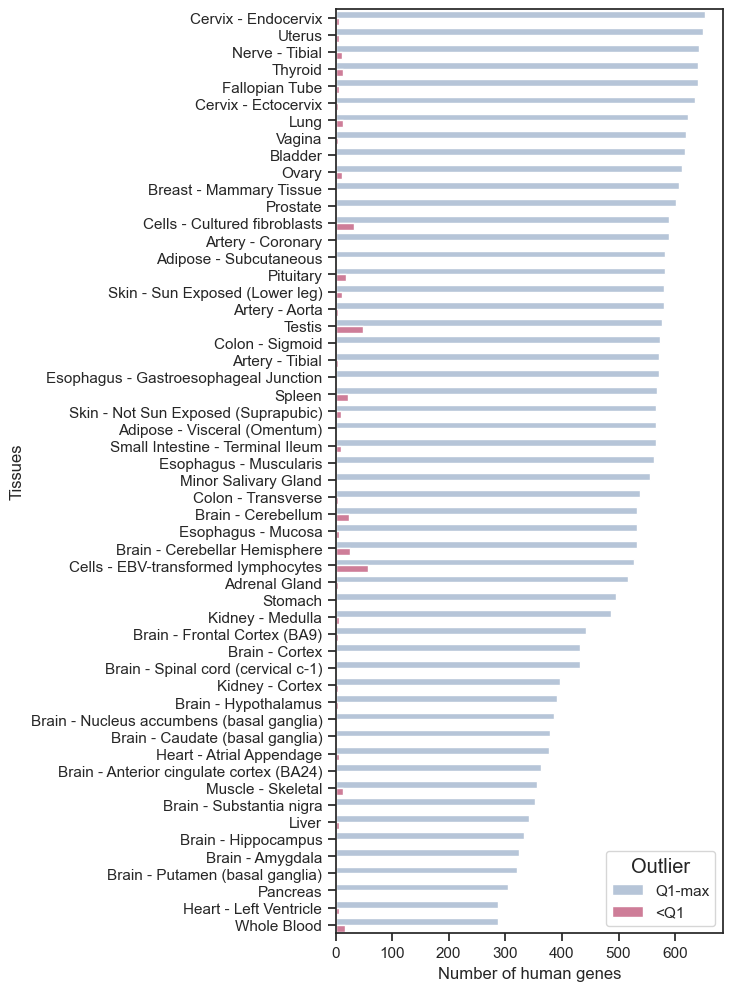

In [87]:
# tissues and number of genes, human

plt.figure(figsize=(5, 12))

counts_tissue_human = counts_tissue_human.sort_values("count_gene", ascending=False)

sns.barplot(data=counts_tissue_human, y="tissue", x="count_gene", hue="out", palette=palette_groups)

plt.xlabel('Number of human genes')
plt.ylabel('Tissues')
plt.legend(title="Outlier", title_fontsize="large", loc='lower right')

plt.savefig('../pictures/plei_16_counts_tissue_human_2_vert.png', dpi=300, bbox_inches='tight')

plt.show()


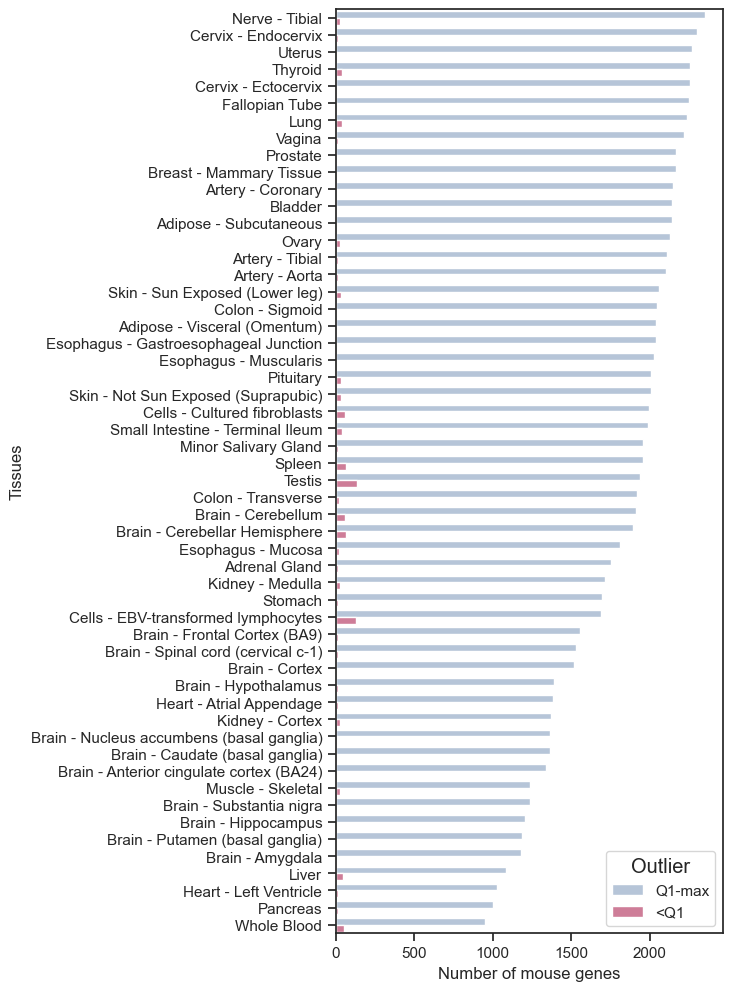

In [88]:
# tissues and number of genes, mouse

plt.figure(figsize=(5, 12))

counts_tissue_mouse = counts_tissue_mouse.sort_values("count_gene", ascending=False)

sns.barplot(data=counts_tissue_mouse, y="tissue", x="count_gene", hue="out", palette=palette_groups)

plt.xlabel('Number of mouse genes')
plt.ylabel('Tissues')
plt.legend(title="Outlier", title_fontsize="large", loc='lower right')

plt.savefig('../pictures/plei_17_counts_tissue_mouse_2_vert.png', dpi=300, bbox_inches='tight')

plt.show()

### Part 7 - Add evolutionary conservation levels and compare them (using gnomAD data)

In [89]:
# importing the gnomAD constraint table

gnomad_data = pd.read_csv("../databases/constraint_gnomAD.txt",
                   delimiter='\t')
gnomad_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19658 entries, 0 to 19657
Data columns (total 77 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gene                19658 non-null  object 
 1   transcript          19658 non-null  object 
 2   obs_mis             19658 non-null  int64  
 3   exp_mis             19658 non-null  float64
 4   oe_mis              19657 non-null  float64
 5   mu_mis              19658 non-null  float64
 6   possible_mis        19658 non-null  int64  
 7   obs_mis_pphen       19333 non-null  float64
 8   exp_mis_pphen       19333 non-null  float64
 9   oe_mis_pphen        19320 non-null  float64
 10  possible_mis_pphen  19333 non-null  float64
 11  obs_syn             19658 non-null  int64  
 12  exp_syn             19658 non-null  float64
 13  oe_syn              19657 non-null  float64
 14  mu_syn              19658 non-null  float64
 15  possible_syn        19658 non-null  int64  
 16  obs_

In [90]:
# determine the number of unique genes
unique_genes = gnomad_data['gene'].nunique()
print("Number of unique genes:", unique_genes)

# determine the number of duplicates
duplicate_genes = gnomad_data['gene'].duplicated().sum()
print("Number of duplicate genes:", duplicate_genes)

Number of unique genes: 19658
Number of duplicate genes: 0


In [91]:
# leave only the necessary parameters in the dataframe

gnomad_data = gnomad_data.loc[:, ['gene', 'oe_lof_upper', 'pLI', 'mis_z']]

In [92]:
# merge the dataframes gnomad_data and main_HPO_table

merged_gnomad = main_HPO_table.merge(gnomad_data, how='left', left_on='gene_human', right_on='gene')
merged_gnomad = merged_gnomad.drop('gene', axis=1)

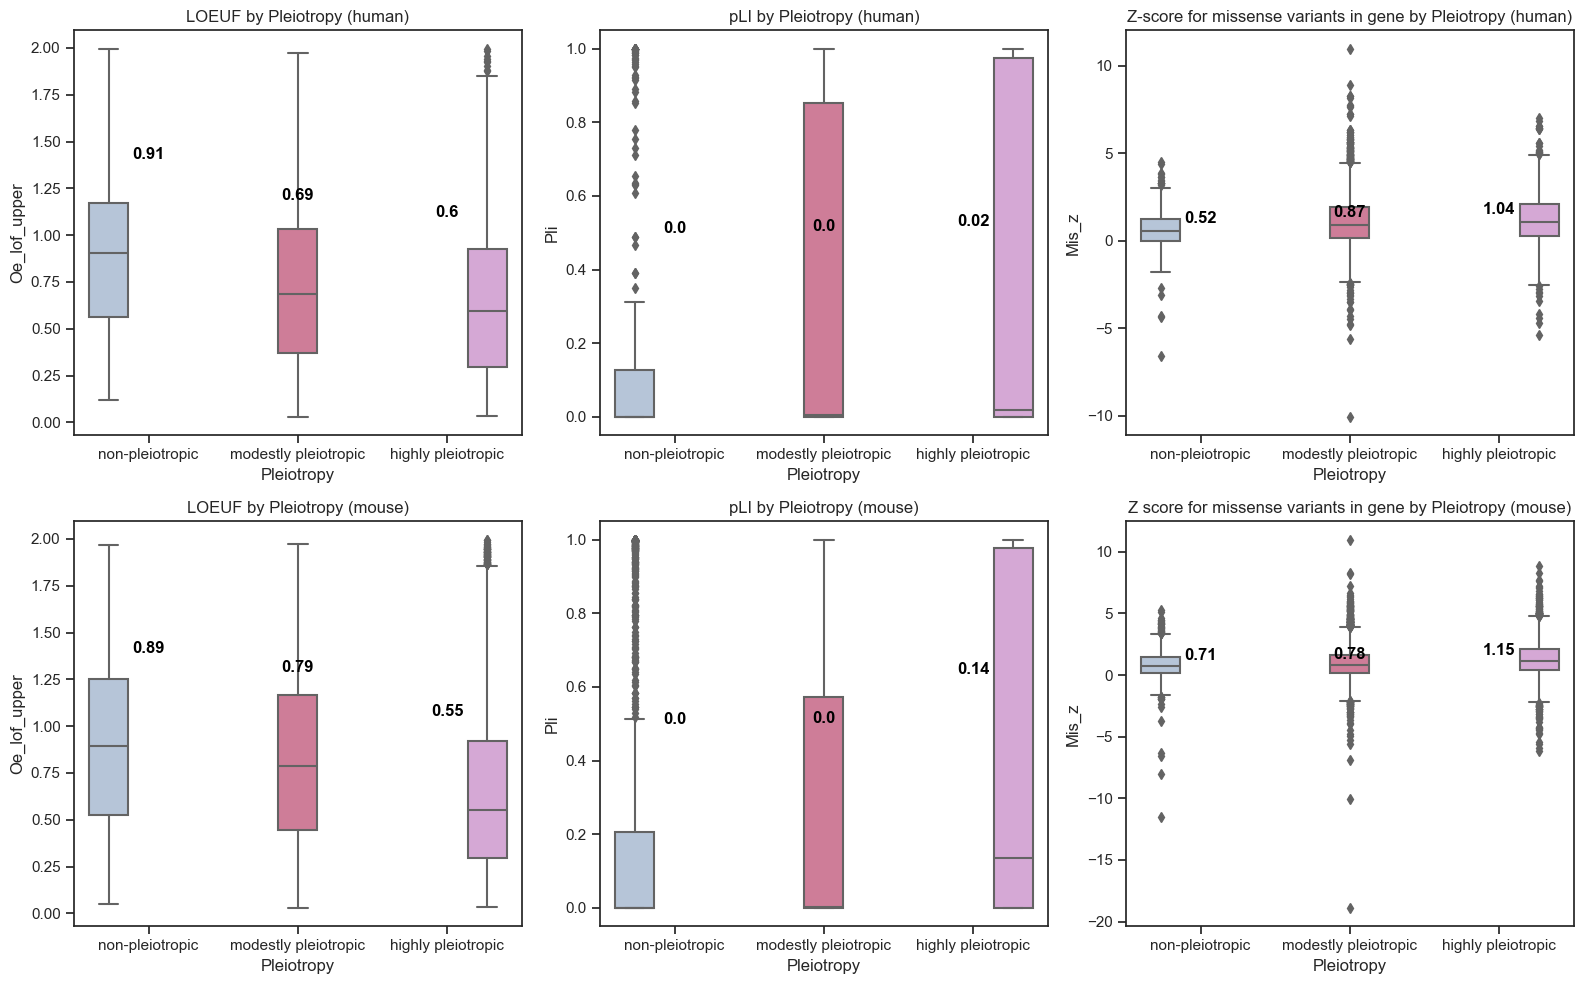

In [93]:
# visualize the constraint in pleiotropy groups for human and mouse genes
merged_gnomad['ply_HPO'] = merged_gnomad['pleiotropy_HPO'].replace({0.0: 'non-pleiotropic', 1.0: 'modestly pleiotropic', 2.0: 'highly pleiotropic'}).astype('category')
cat_ply_HPO = merged_gnomad['ply_HPO'].cat.reorder_categories(['non-pleiotropic', 'modestly pleiotropic', 'highly pleiotropic'])
merged_gnomad['ply_HPO'] = cat_ply_HPO

merged_gnomad['ply_MPO'] = merged_gnomad['pleiotropy_MPO'].replace({0.0: 'non-pleiotropic', 1.0: 'modestly pleiotropic', 2.0: 'highly pleiotropic'}).astype('category')
cat_ply_MPO = merged_gnomad['ply_MPO'].cat.reorder_categories(['non-pleiotropic', 'modestly pleiotropic', 'highly pleiotropic'])
merged_gnomad['ply_MPO'] = cat_ply_MPO


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))

datasets = [{'x': 'ply_HPO', 'y': 'oe_lof_upper', 'hue': 'ply_HPO', 'title': 'LOEUF by Pleiotropy (human)'},
            {'x': 'ply_HPO', 'y': 'pLI', 'hue': 'ply_HPO', 'title': 'pLI by Pleiotropy (human)'},
            {'x': 'ply_HPO', 'y': 'mis_z', 'hue': 'ply_HPO', 'title': 'Z-score for missense variants in gene by Pleiotropy (human)'},
            {'x': 'ply_MPO', 'y': 'oe_lof_upper', 'hue': 'ply_MPO', 'title': 'LOEUF by Pleiotropy (mouse)'},
            {'x': 'ply_MPO', 'y': 'pLI', 'hue': 'ply_MPO', 'title': 'pLI by Pleiotropy (mouse)'},
            {'x': 'ply_MPO', 'y': 'mis_z', 'hue': 'ply_MPO', 'title': 'Z score for missense variants in gene by Pleiotropy (mouse)'}]

for i, ax in enumerate(axes.flat):
    data = datasets[i]
    sns.boxplot(ax=ax, x=data['x'], y=data['y'], hue=data['hue'], data=merged_gnomad, palette=palette_groups)
    ax.set_xlabel('Pleiotropy')
    ax.set_ylabel(data['y'].capitalize())
    ax.set_title(data['title'])
    ax.legend().set_visible(False)
    
    medians = merged_gnomad.groupby(data['x'])[data['y']].median().values
    median_labels = [str(np.round(s, 2)) for s in medians]

    pos = range(len(medians))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 0.5, median_labels[tick], 
                horizontalalignment='center', size='medium', color='black', weight='semibold')


plt.tight_layout()

plt.savefig('../pictures/plei_18_constraint.png', dpi=300)

plt.show()

In [94]:
# save the file with constraint in pleiotropy groups

constraint = merged_gnomad.loc[:, ['entrez_id_human', 'entrez_id_mouse', 'pleiotropy_HPO', 'pleiotropy_MPO',
                                   'oe_lof_upper', 'pLI', 'mis_z']].copy()

constraint.to_csv("../intermediate_data/constraint.csv", index=False)

In [95]:
merged_gnomad.columns

Index(['gene_human', 'entrez_id_human', 'gene_mouse', 'MGI', 'entrez_id_mouse',
       'MP_low_level', 'HP_low_level', 'MP_high_level', 'HP_high_level_human',
       'HP_high_level', 'HP_count', 'HP_high_count', 'MP_count',
       'MP_high_count', 'pleiotropy_HPO', 'pleiotropy_MPO',
       'HP_name_high_level', 'MP_name_high_level', 'oe_lof_upper', 'pLI',
       'mis_z', 'ply_HPO', 'ply_MPO'],
      dtype='object')

In [96]:
merged_gnomad = merged_gnomad.loc[:, ['gene_human', 'entrez_id_human', 'gene_mouse', 'entrez_id_mouse', 
                                      'MP_low_level', 'HP_low_level', 'MP_high_level', 'HP_high_level', 
                                      'HP_high_count', 'MP_high_count', 'pleiotropy_HPO', 'pleiotropy_MPO', 
                                      'HP_name_high_level', 'MP_name_high_level', 'oe_lof_upper', 'pLI', 'mis_z']]

In [97]:
# calculate outlier for oe_lof_upper column
outlier_limits_h = {}
outlier_limits_m = {}

for hpo in [0, 1, 2]:
    Q1_h = merged_gnomad.loc[(merged_gnomad['pleiotropy_HPO'] == hpo), 'oe_lof_upper'].quantile(0.25)
    Q3_h = merged_gnomad.loc[(merged_gnomad['pleiotropy_HPO'] == hpo), 'oe_lof_upper'].quantile(0.75)

    outlier_limits_h[hpo] = (Q1_h, Q3_h)
    
for mpo in [0, 1, 2]:
    Q1_m = merged_gnomad.loc[(merged_gnomad['pleiotropy_MPO'] == mpo), 'oe_lof_upper'].quantile(0.25)
    Q3_m = merged_gnomad.loc[(merged_gnomad['pleiotropy_MPO'] == mpo), 'oe_lof_upper'].quantile(0.75)

    outlier_limits_m[mpo] = (Q1_m, Q3_m)


merged_gnomad['outlier_oe_lof_upper_h'] = 0
merged_gnomad['outlier_oe_lof_upper_m'] = 0


for hpo, limits in outlier_limits_h.items():
    merged_gnomad.loc[(merged_gnomad['pleiotropy_HPO'] == hpo) & (merged_gnomad['oe_lof_upper'] < limits[0]), 'outlier_oe_lof_upper_h'] = -1
    merged_gnomad.loc[(merged_gnomad['pleiotropy_HPO'] == hpo) & (merged_gnomad['oe_lof_upper'] > limits[1]), 'outlier_oe_lof_upper_h'] = 1


for mpo, limits in outlier_limits_m.items():
    merged_gnomad.loc[(merged_gnomad['pleiotropy_MPO'] == mpo) & (merged_gnomad['oe_lof_upper'] < limits[0]), 'outlier_oe_lof_upper_m'] = -1
    merged_gnomad.loc[(merged_gnomad['pleiotropy_MPO'] == mpo) & (merged_gnomad['oe_lof_upper'] > limits[1]), 'outlier_oe_lof_upper_m'] = 1

In [98]:
# calculate outlier for pLI column
outlier_limits_h = {}
outlier_limits_m = {}

for hpo in [0, 1, 2]:
    Q1_h = merged_gnomad.loc[(merged_gnomad['pleiotropy_HPO'] == hpo), 'pLI'].quantile(0.25)
    Q3_h = merged_gnomad.loc[(merged_gnomad['pleiotropy_HPO'] == hpo), 'pLI'].quantile(0.75)

    outlier_limits_h[hpo] = (Q1_h, Q3_h)
    
for mpo in [0, 1, 2]:
    Q1_m = merged_gnomad.loc[(merged_gnomad['pleiotropy_MPO'] == mpo), 'pLI'].quantile(0.25)
    Q3_m = merged_gnomad.loc[(merged_gnomad['pleiotropy_MPO'] == mpo), 'pLI'].quantile(0.75)

    outlier_limits_m[mpo] = (Q1_m, Q3_m)


merged_gnomad['outlier_pLI_h'] = 0
merged_gnomad['outlier_pLI_m'] = 0


for hpo, limits in outlier_limits_h.items():
    merged_gnomad.loc[(merged_gnomad['pleiotropy_HPO'] == hpo) & (merged_gnomad['pLI'] < limits[0]), 'outlier_pLI_h'] = -1
    merged_gnomad.loc[(merged_gnomad['pleiotropy_HPO'] == hpo) & (merged_gnomad['pLI'] > limits[1]), 'outlier_pLI_h'] = 1


for mpo, limits in outlier_limits_m.items():
    merged_gnomad.loc[(merged_gnomad['pleiotropy_MPO'] == mpo) & (merged_gnomad['pLI'] < limits[0]), 'outlier_pLI_m'] = -1
    merged_gnomad.loc[(merged_gnomad['pleiotropy_MPO'] == mpo) & (merged_gnomad['pLI'] > limits[1]), 'outlier_pLI_m'] = 1

In [99]:
# calculate outlier for mis_z column
outlier_limits_h = {}
outlier_limits_m = {}

for hpo in [0, 1, 2]:
    Q1_h = merged_gnomad.loc[(merged_gnomad['pleiotropy_HPO'] == hpo), 'mis_z'].quantile(0.25)
    Q3_h = merged_gnomad.loc[(merged_gnomad['pleiotropy_HPO'] == hpo), 'mis_z'].quantile(0.75)

    outlier_limits_h[hpo] = (Q1_h, Q3_h)
    
for mpo in [0, 1, 2]:
    Q1_m = merged_gnomad.loc[(merged_gnomad['pleiotropy_MPO'] == mpo), 'mis_z'].quantile(0.25)
    Q3_m = merged_gnomad.loc[(merged_gnomad['pleiotropy_MPO'] == mpo), 'mis_z'].quantile(0.75)

    outlier_limits_m[mpo] = (Q1_m, Q3_m)


merged_gnomad['outlier_mis_z_h'] = 0
merged_gnomad['outlier_mis_z_m'] = 0


for hpo, limits in outlier_limits_h.items():
    merged_gnomad.loc[(merged_gnomad['pleiotropy_HPO'] == hpo) & (merged_gnomad['mis_z'] < limits[0]), 'outlier_mis_z_h'] = -1
    merged_gnomad.loc[(merged_gnomad['pleiotropy_HPO'] == hpo) & (merged_gnomad['mis_z'] > limits[1]), 'outlier_mis_z_h'] = 1


for mpo, limits in outlier_limits_m.items():
    merged_gnomad.loc[(merged_gnomad['pleiotropy_MPO'] == mpo) & (merged_gnomad['mis_z'] < limits[0]), 'outlier_mis_z_m'] = -1
    merged_gnomad.loc[(merged_gnomad['pleiotropy_MPO'] == mpo) & (merged_gnomad['mis_z'] > limits[1]), 'outlier_mis_z_m'] = 1

In [100]:
# output the column names

merged_gnomad.columns

Index(['gene_human', 'entrez_id_human', 'gene_mouse', 'entrez_id_mouse',
       'MP_low_level', 'HP_low_level', 'MP_high_level', 'HP_high_level',
       'HP_high_count', 'MP_high_count', 'pleiotropy_HPO', 'pleiotropy_MPO',
       'HP_name_high_level', 'MP_name_high_level', 'oe_lof_upper', 'pLI',
       'mis_z', 'outlier_oe_lof_upper_h', 'outlier_oe_lof_upper_m',
       'outlier_pLI_h', 'outlier_pLI_m', 'outlier_mis_z_h', 'outlier_mis_z_m'],
      dtype='object')

In [101]:
# check the size of the subsets - Human

print(merged_gnomad[(merged_gnomad['pleiotropy_HPO'] == 0) & (merged_gnomad['outlier_oe_lof_upper_h'] == 1)].shape)
print(merged_gnomad[(merged_gnomad['pleiotropy_HPO'] == 0) & (merged_gnomad['outlier_pLI_h'] == 1)].shape)
print(merged_gnomad[(merged_gnomad['pleiotropy_HPO'] == 0) & (merged_gnomad['outlier_mis_z_h'] == 1)].shape)

(65, 23)
(65, 23)
(65, 23)


In [102]:
# check the size of the subsets - Mouse

print(merged_gnomad[(merged_gnomad['pleiotropy_MPO'] == 0) & (merged_gnomad['outlier_oe_lof_upper_m'] == 1)].shape)
print(merged_gnomad[(merged_gnomad['pleiotropy_MPO'] == 0) & (merged_gnomad['outlier_pLI_m'] == 1)].shape)
print(merged_gnomad[(merged_gnomad['pleiotropy_MPO'] == 0) & (merged_gnomad['outlier_mis_z_m'] == 1)].shape)

(277, 23)
(278, 23)
(279, 23)
